# Exploratory Data Analysis

# Questions to answer 

- Is location a key consideration for rent?
- Does quantity supplied affect the price of rent?
- Does the size of the state affect rent?
- Do macro economic factors such as population and regional GDP affect rent?
- Did rent increase over the three years that the data set was collected?
- Is rent stable in certain states versus others?
- Which of the advertized features in the data set affect rent?

# Imports 

In [1]:
import pandas as pd
from datetime import datetime
from datetime import date
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.optimize as opt
from scipy import stats
from zipfile import ZipFile
import urllib
import csv
import io
import geopandas as gpd
import lxml

# Rentals data 

In [2]:
#Load rentals and view data
immo_data = pd.read_csv('../data/processed/rentals_cleaned_final.csv')

In [3]:
rentals = immo_data.copy()

In [4]:
rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267690 entries, 0 to 267689
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   state                267690 non-null  object 
 1   serviceCharge        257456 non-null  float64
 2   tvOffer              267690 non-null  object 
 3   newlyConst           267690 non-null  bool   
 4   balcony              267690 non-null  bool   
 5   picturecount         267690 non-null  int64  
 6   internetUploadSpeed  234564 non-null  float64
 7   yearConstructed      210546 non-null  object 
 8   hasKitchen           267690 non-null  bool   
 9   cellar               267690 non-null  bool   
 10  baseRent             267670 non-null  float64
 11  livingSpace          267690 non-null  float64
 12  condition            267690 non-null  object 
 13  interiorQual         267690 non-null  object 
 14  petsAllowed          153672 non-null  object 
 15  lift             

In [5]:
rentals.head()

,state,serviceCharge,tvOffer,newlyConst,balcony,picturecount,internetUploadSpeed,yearConstructed,hasKitchen,cellar,...,floor,numberOfFloors,garden,city_town,municipality,description,facilities,heatingCosts,lastRefurbish,date
0,Nordrhein_Westfalen,245.00,ONE_YEAR_FREE,False,False,6,10.0,1965-01-01,False,True,...,1.0,3.0,True,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,NaN,NaN,2019-05-01
1,Rheinland_Pfalz,134.00,ONE_YEAR_FREE,False,True,8,10.0,1871-01-01,False,False,...,NaN,NaN,False,Rhein_Pfalz,Böhl_Iggelheim,Alles neu macht der Mai – so kann es auch für ...,NaN,NaN,2019-01-01,2019-05-01
2,Sachsen,255.00,ONE_YEAR_FREE,True,True,8,2.4,2019-01-01,False,True,...,3.0,4.0,False,Dresden,Äußere_Neustadt_Antonstadt,Der Neubau entsteht im Herzen der Dresdner Neu...,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",NaN,NaN,2019-10-01
3,Sachsen,58.15,ONE_YEAR_FREE,False,True,9,40.0,1964-01-01,False,False,...,3.0,NaN,False,Mittelsachsen,Freiberg,Abseits von Lärm und Abgasen in Ihre neue Wohn...,NaN,87.23,NaN,2019-05-01
4,Bremen,138.00,NONE,False,True,19,NaN,1950-01-01,False,False,...,1.0,NaN,False,Bremen,Neu_Schwachhausen,Es handelt sich hier um ein saniertes Mehrfami...,Diese Wohnung wurde neu saniert und ist wie fo...,NaN,NaN,2020-02-01


### Convert features to appropriate data type

In [6]:
#Convert yearConstructed, lastRefurbish and date to datetime
rentals.yearConstructed = pd.to_datetime(rentals.yearConstructed)
rentals.lastRefurbish = pd.to_datetime(rentals.lastRefurbish)
rentals.date = pd.to_datetime(rentals.date)

In [7]:
#Convert zip_code to object
rentals.zip_code = rentals.zip_code.astype('object')
rentals.dtypes['zip_code']

dtype('O')

# Relationship between base rent and time

## Change in base rent over the period  of time when the data was scraped (2018, 2019, 2020)

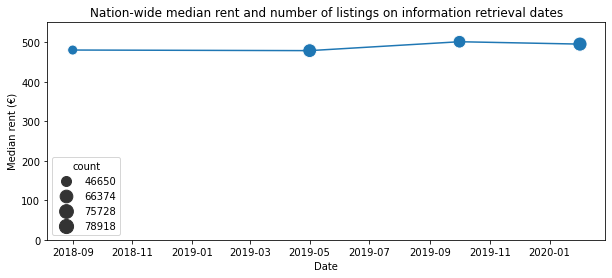

In [8]:
#Plot the median base rent change over the period of time the data was collected
plt.figure(figsize = (10, 4))
sns.lineplot(data = rentals.groupby('date')['baseRent'].agg(['median', 'count']), x = 'date', y = 'median')
sns.scatterplot(data = rentals.groupby('date')['baseRent']\
                .agg(['median', 'count']), x = 'date', y = 'median', marker = 'o', size = 'count', sizes = (100,200))
plt.ylim(0, 550)
plt.title('Nation-wide median rent and number of listings on information retrieval dates')
plt.ylabel('Median rent (€)')
plt.xlabel('Date')
plt.savefig('../reports/figures/date.png', bbox_inches="tight");

In [9]:
rentals.groupby('date')['baseRent'].agg(['median', 'count'])

,median,count
date,,
2018-09-01,480.0,46650
2019-05-01,478.5,75728
2019-10-01,501.0,66374
2020-02-01,495.0,78918


We observe that there is minimal variation in the median base rent over the four dates when the data was collected.  

## Relationship between base rent and the year property was constructed

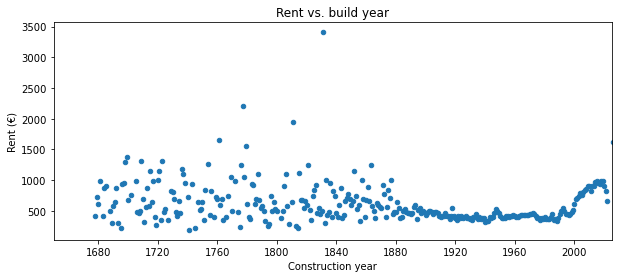

In [10]:
yearConstructed = rentals.groupby('yearConstructed')[['baseRent']].median()
yearConstructed.reset_index().plot(x = 'yearConstructed', y = 'baseRent', kind = 'scatter', figsize = (10, 4))
plt.title('Rent vs. build year')
plt.xlabel('Construction year')
plt.ylabel('Rent (€)')
start = datetime.strptime('1650', '%Y')
end = datetime.strptime('2025', '%Y')
plt.xlim([start, end])
#plt.tick_params(labelsize = 12)
plt.savefig('../reports/figures/yearConstructed.png', bbox_inches="tight");

An  interest, There is no clear relationship between a property was built and the base rent for the property.

## Relationship between baseRent and the year property was last refurbished

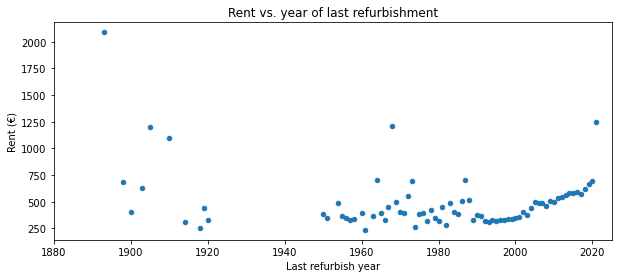

In [11]:
lastRefurbish = rentals.groupby('lastRefurbish')[['baseRent']].median()
lastRefurbish.reset_index().plot(x = 'lastRefurbish', y = 'baseRent', kind = 'scatter', figsize = (10, 4))
plt.title('Rent vs. year of last refurbishment')
plt.xlabel('Last refurbish year')
plt.ylabel('Rent (€)')
start = datetime.strptime('1880', '%Y')
end = datetime.strptime('2025', '%Y')
plt.xlim([start, end])
plt.savefig('../reports/figures/lastRefurbished.png', bbox_inches="tight");
#plt.tick_params(labelsize = 12);

There is no clear relationship between the last time a property was refurbished and the base rent for the property.

# Creating dataframes for state, city/town, municipality and zip codes

In [12]:
#Create aggregation for state-level information
state_summary = rentals.groupby('state').agg(\
                                             noListings_state = pd.NamedAgg(column = 'baseRent', aggfunc = 'count'), \
                                             noZipCodes_state = pd.NamedAgg(column = 'zip_code', aggfunc = 'nunique'), \
                                             noMunicipalities_state = pd.NamedAgg(column = 'municipality', aggfunc = 'nunique'), \
                                             noCitiesTowns = pd.NamedAgg(column = 'city_town', aggfunc = 'nunique'), \
                                             totalNoRooms_state = pd.NamedAgg(column = 'noRooms', aggfunc = 'sum'), \
                                             medianNoRooms_state = pd.NamedAgg(column = 'noRooms', aggfunc = 'median'), \
                                             totalLivingSpace_state = pd.NamedAgg(column = 'livingSpace', aggfunc = 'sum'), \
                                             medianLivingSpace_state = pd.NamedAgg(column = 'livingSpace', aggfunc = 'median'), \
                                             medianServiceCharge_state = pd.NamedAgg(column = 'serviceCharge', aggfunc = 'median'), \
                                             medianInternetUploadSpeed_state = pd.NamedAgg(column = 'internetUploadSpeed', aggfunc = 'median'), \
                                             medianBaseRent_state = pd.NamedAgg(column = 'baseRent', aggfunc = 'median'), \
                                             medianThermalChar_state = pd.NamedAgg(column = 'thermalChar', aggfunc = 'median'), \
                                             medianFloor_state = pd.NamedAgg(column = 'floor', aggfunc = 'median'), \
                                             medianNoFloors_state = pd.NamedAgg(column = 'numberOfFloors', aggfunc = 'median'), \
                                             medianHeatingCosts_state = pd.NamedAgg(column = 'heatingCosts', aggfunc = 'median'), \
                                             medianPictureCount_state = pd.NamedAgg(column = 'picturecount', aggfunc = 'median'))

In [13]:
state_summary

,noListings_state,noZipCodes_state,noMunicipalities_state,noCitiesTowns,totalNoRooms_state,medianNoRooms_state,totalLivingSpace_state,medianLivingSpace_state,medianServiceCharge_state,medianInternetUploadSpeed_state,medianBaseRent_state,medianThermalChar_state,medianFloor_state,medianNoFloors_state,medianHeatingCosts_state,medianPictureCount_state
state,,,,,,,,,,,,,,,,
Baden_Württemberg,16015,1104,1048,42,45879.70,3.0,1347084.94,81.245,170.000,40.0,850.000,99.00,2.0,3.0,76.525,9.0
Bayern,21531,1535,1656,81,57132.10,3.0,1722613.18,76.000,160.000,40.0,850.000,98.80,2.0,3.0,80.000,10.0
Berlin,10342,214,79,1,26437.30,2.0,847033.36,72.060,165.000,40.0,945.000,105.00,2.0,5.0,75.280,10.0
Brandenburg,6914,241,334,18,17744.00,3.0,477684.33,62.620,120.000,40.0,392.770,95.50,2.0,3.0,70.000,7.0
Bremen,2958,45,88,2,7726.00,3.0,215605.10,68.000,140.000,40.0,500.000,122.95,2.0,3.0,72.000,8.0
Hamburg,3740,109,94,1,10141.40,3.0,312940.64,76.000,180.000,40.0,1014.345,103.00,2.0,3.0,80.000,10.0
Hessen,17729,556,485,25,48611.50,3.0,1470552.18,78.900,190.000,40.0,820.000,112.00,2.0,3.0,80.000,10.0
Mecklenburg_Vorpommern,6621,197,462,18,16866.30,3.0,419085.94,60.400,107.425,40.0,344.000,91.10,2.0,3.0,70.000,7.0
Niedersachsen,16536,709,818,46,45461.00,3.0,1272668.41,72.640,134.000,40.0,523.850,123.00,1.0,3.0,75.000,8.0


In [14]:
#Create aggregation for city_town-level information
city_town_summary = rentals.groupby('city_town').agg(\
                                             noListings_ct = pd.NamedAgg(column = 'baseRent', aggfunc = 'count'), \
                                             noZipCodes_ct = pd.NamedAgg(column = 'zip_code', aggfunc = 'nunique'), \
                                             noMunicipalities_ct = pd.NamedAgg(column = 'municipality', aggfunc = 'nunique'), \
                                             totalNoRooms_ct = pd.NamedAgg(column = 'noRooms', aggfunc = 'sum'), \
                                             medianNoRooms_ct = pd.NamedAgg(column = 'noRooms', aggfunc = 'median'), \
                                             totalLivingSpace_ct = pd.NamedAgg(column = 'livingSpace', aggfunc = 'sum'), \
                                             medianLivingSpace_ct = pd.NamedAgg(column = 'livingSpace', aggfunc = 'median'), \
                                             medianServiceCharge_ct = pd.NamedAgg(column = 'serviceCharge', aggfunc = 'median'), \
                                             medianInternetUploadSpeed_ct = pd.NamedAgg(column = 'internetUploadSpeed', aggfunc = 'median'), \
                                             medianBaseRent_ct = pd.NamedAgg(column = 'baseRent', aggfunc = 'median'), \
                                             medianThermalChar_ct = pd.NamedAgg(column = 'thermalChar', aggfunc = 'median'), \
                                             medianFloor_ct = pd.NamedAgg(column = 'floor', aggfunc = 'median'), \
                                             medianNoFloors_ct = pd.NamedAgg(column = 'numberOfFloors', aggfunc = 'median'), \
                                             medianHeatingCosts_ct = pd.NamedAgg(column = 'heatingCosts', aggfunc = 'median'), \
                                             medianPictureCount_ct = pd.NamedAgg(column = 'picturecount', aggfunc = 'median'))
city_town_summary.head()

,noListings_ct,noZipCodes_ct,noMunicipalities_ct,totalNoRooms_ct,medianNoRooms_ct,totalLivingSpace_ct,medianLivingSpace_ct,medianServiceCharge_ct,medianInternetUploadSpeed_ct,medianBaseRent_ct,medianThermalChar_ct,medianFloor_ct,medianNoFloors_ct,medianHeatingCosts_ct,medianPictureCount_ct
city_town,,,,,,,,,,,,,,,
Aachen,2836,28,45,7132.5,2.5,206147.04,70.000,150.0,10.0,570.0,116.6,2.0,3.0,72.0,9.0
Ahrweiler,317,18,25,849.5,3.0,26621.03,78.000,150.0,40.0,570.0,111.5,1.0,3.0,68.0,9.0
Aichach_Friedberg,131,19,18,395.0,3.0,11642.27,85.000,150.0,40.0,795.0,72.8,1.0,2.0,80.0,10.0
Alb_Donau,193,31,29,583.5,3.0,16548.47,84.000,150.0,40.0,750.0,81.0,1.0,3.0,100.0,8.0
Altenburger_Land,600,9,21,1503.5,2.0,38266.38,60.715,110.0,40.0,300.0,115.0,2.0,3.0,65.0,8.0


In [15]:
#Create aggregation for municipality-level information
municipality_summary = rentals.groupby('municipality').agg(\
                                             noListings_muni = pd.NamedAgg(column = 'baseRent', aggfunc = 'count'), \
                                             noZipCodes_muni = pd.NamedAgg(column = 'zip_code', aggfunc = 'nunique'), \
                                             totalNoRooms_muni = pd.NamedAgg(column = 'noRooms', aggfunc = 'sum'), \
                                             medianNoRooms_muni = pd.NamedAgg(column = 'noRooms', aggfunc = 'median'), \
                                             totalLivingSpace_muni = pd.NamedAgg(column = 'livingSpace', aggfunc = 'sum'), \
                                             medianLivingSpace_muni = pd.NamedAgg(column = 'livingSpace', aggfunc = 'median'), \
                                             medianServiceCharge_muni = pd.NamedAgg(column = 'serviceCharge', aggfunc = 'median'), \
                                             medianInternetUploadSpeed_muni = pd.NamedAgg(column = 'internetUploadSpeed', aggfunc = 'median'), \
                                             medianBaseRent_muni = pd.NamedAgg(column = 'baseRent', aggfunc = 'median'), \
                                             medianThermalChar_muni = pd.NamedAgg(column = 'thermalChar', aggfunc = 'median'), \
                                             medianFloor_muni = pd.NamedAgg(column = 'floor', aggfunc = 'median'), \
                                             medianNoFloors_muni = pd.NamedAgg(column = 'numberOfFloors', aggfunc = 'median'), \
                                             medianHeatingCosts_muni = pd.NamedAgg(column = 'heatingCosts', aggfunc = 'median'), \
                                             medianPictureCount_muni = pd.NamedAgg(column = 'picturecount', aggfunc = 'median'))
municipality_summary.head()                                          

,noListings_muni,noZipCodes_muni,totalNoRooms_muni,medianNoRooms_muni,totalLivingSpace_muni,medianLivingSpace_muni,medianServiceCharge_muni,medianInternetUploadSpeed_muni,medianBaseRent_muni,medianThermalChar_muni,medianFloor_muni,medianNoFloors_muni,medianHeatingCosts_muni,medianPictureCount_muni
municipality,,,,,,,,,,,,,,
Aach,4,2,15.0,4.0,441.00,115.500,175.0,2.4,915.00,83.200,1.0,2.0,NaN,13.5
Aachen_Eilendorf,65,2,169.5,3.0,4743.62,75.000,150.0,2.4,615.00,81.500,2.0,3.0,60.0,9.0
Aalen,61,6,160.5,3.0,4346.87,72.000,150.0,40.0,670.00,81.825,1.0,3.0,48.5,7.0
Aarbergen,22,2,67.0,3.0,1767.73,72.585,158.5,21.2,441.51,175.000,2.0,3.0,80.0,10.0
Aaseestadt,21,1,49.0,2.0,1542.27,71.400,172.5,40.0,1098.00,47.500,1.0,2.0,33.0,6.0


In [16]:
#Create aggregation for zip_code-level information
zip_code_summary = rentals.groupby('zip_code').agg(\
                                             noListings_zip = pd.NamedAgg(column = 'baseRent', aggfunc = 'count'), \
                                             totalNoRooms_zip = pd.NamedAgg(column = 'noRooms', aggfunc = 'sum'), \
                                             medianNoRooms_zip = pd.NamedAgg(column = 'noRooms', aggfunc = 'median'), \
                                             medianLivingSpace_zip = pd.NamedAgg(column = 'livingSpace', aggfunc = 'median'), \
                                             totalLivingSpace_zip = pd.NamedAgg(column = 'livingSpace', aggfunc = 'sum'), \
                                             medianServiceCharge_zip= pd.NamedAgg(column = 'serviceCharge', aggfunc = 'median'), \
                                             medianInternetUploadSpeed_zip = pd.NamedAgg(column = 'internetUploadSpeed', aggfunc = 'median'), \
                                             medianBaseRent_zip = pd.NamedAgg(column = 'baseRent', aggfunc = 'median'), \
                                             medianThermalChar_zip = pd.NamedAgg(column = 'thermalChar', aggfunc = 'median'), \
                                             medianFloor_zip = pd.NamedAgg(column = 'floor', aggfunc = 'median'), \
                                             medianNoFloors_zip = pd.NamedAgg(column = 'numberOfFloors', aggfunc = 'median'), \
                                             medianHeatingCosts_zip = pd.NamedAgg(column = 'heatingCosts', aggfunc = 'median'), \
                                             medianPictureCount_zip = pd.NamedAgg(column = 'picturecount', aggfunc = 'median'))
zip_code_summary.head()                                          

,noListings_zip,totalNoRooms_zip,medianNoRooms_zip,medianLivingSpace_zip,totalLivingSpace_zip,medianServiceCharge_zip,medianInternetUploadSpeed_zip,medianBaseRent_zip,medianThermalChar_zip,medianFloor_zip,medianNoFloors_zip,medianHeatingCosts_zip,medianPictureCount_zip
zip_code,,,,,,,,,,,,,
852,2,5.0,2.5,61.85,123.70,116.0,5.0,331.500,108.900,2.0,NaN,NaN,9.5
853,1,4.0,4.0,112.31,112.31,225.0,2.4,753.000,NaN,3.0,NaN,NaN,15.0
1057,3,6.0,2.0,49.15,147.45,130.0,10.0,390.000,121.645,3.0,NaN,NaN,6.0
1067,789,2248.7,3.0,83.80,70977.97,200.0,40.0,999.000,68.000,3.0,6.0,72.64,11.0
1069,224,542.0,2.0,62.36,14870.86,110.5,40.0,493.575,88.000,3.0,6.0,77.00,8.0


# State Heatmap

In [17]:
state_location_list = [('Baden_Württemberg' , 48.99999229, 8.399993448),
('Bayern', 50.26660748, 10.96660681),
('Berlin', 52.52181866, 13.40154862),
('Brandenburg', 51.7704175, 14.32996741),
('Bremen', 53.55043805, 8.579982461),
('Hamburg', 53.55002464, 9.999999144),
('Hessen', 51.30000694, 9.500029662),
('Mecklenburg_Vorpommern', 53.63330408, 11.41669861),
('Niedersachsen', 53.1299986, 8.220004434),
('Nordrhein_Westfalen', 52.02998822, 8.530011351),
('Rheinland_Pfalz', 49.98247246, 8.273219156),
('Saarland', 49.25039044, 6.970003213),
('Sachsen', 50.82998395, 12.91997595),
('Sachsen_Anhalt', 52.13042137, 11.62000362),
('Schleswig_Holstein', 54.78374778, 9.433315388),
('Thüringen', 50.97005292, 11.02996212)]

state_location_dict = {}
for state, lat, long in state_location_list:
    state_location_dict[state] = [long, lat]

In [18]:
state_shapes = gpd.read_file('../data/raw/DEU_adm/DEU_adm1.shp')

In [19]:
state_shapes['NAME_1'] = state_shapes.NAME_1.str.replace('-', '_')

In [20]:
state_shapes = state_shapes.rename(columns = {'NAME_1': 'state'})

In [21]:
state_shapes = state_shapes[['state', 'geometry']]

In [22]:
state_metrics = state_summary.reset_index()

In [23]:
select_columns = ['state', 'medianBaseRent_state', 'geometry']

In [24]:
state_metrics_shapes = gpd.GeoDataFrame(pd.merge(state_metrics, state_shapes, on = 'state', how = 'inner'))
state_metrics_shapes.head()

,state,noListings_state,noZipCodes_state,noMunicipalities_state,noCitiesTowns,totalNoRooms_state,medianNoRooms_state,totalLivingSpace_state,medianLivingSpace_state,medianServiceCharge_state,medianInternetUploadSpeed_state,medianBaseRent_state,medianThermalChar_state,medianFloor_state,medianNoFloors_state,medianHeatingCosts_state,medianPictureCount_state,geometry
0,Baden_Württemberg,16015,1104,1048,42,45879.7,3.0,1347084.94,81.245,170.0,40.0,850.00,99.00,2.0,3.0,76.525,9.0,"MULTIPOLYGON (((8.70837 47.71556, 8.70918 47.7..."
1,Bayern,21531,1535,1656,81,57132.1,3.0,1722613.18,76.000,160.0,40.0,850.00,98.80,2.0,3.0,80.000,10.0,"POLYGON ((10.13386 50.55000, 10.13980 50.54252..."
2,Berlin,10342,214,79,1,26437.3,2.0,847033.36,72.060,165.0,40.0,945.00,105.00,2.0,5.0,75.280,10.0,"POLYGON ((13.17789 52.39032, 13.16575 52.39050..."
3,Brandenburg,6914,241,334,18,17744.0,3.0,477684.33,62.620,120.0,40.0,392.77,95.50,2.0,3.0,70.000,7.0,"POLYGON ((13.87951 53.50107, 13.87927 53.49908..."
4,Bremen,2958,45,88,2,7726.0,3.0,215605.10,68.000,140.0,40.0,500.00,122.95,2.0,3.0,72.000,8.0,"MULTIPOLYGON (((8.50506 53.23289, 8.51754 53.2..."


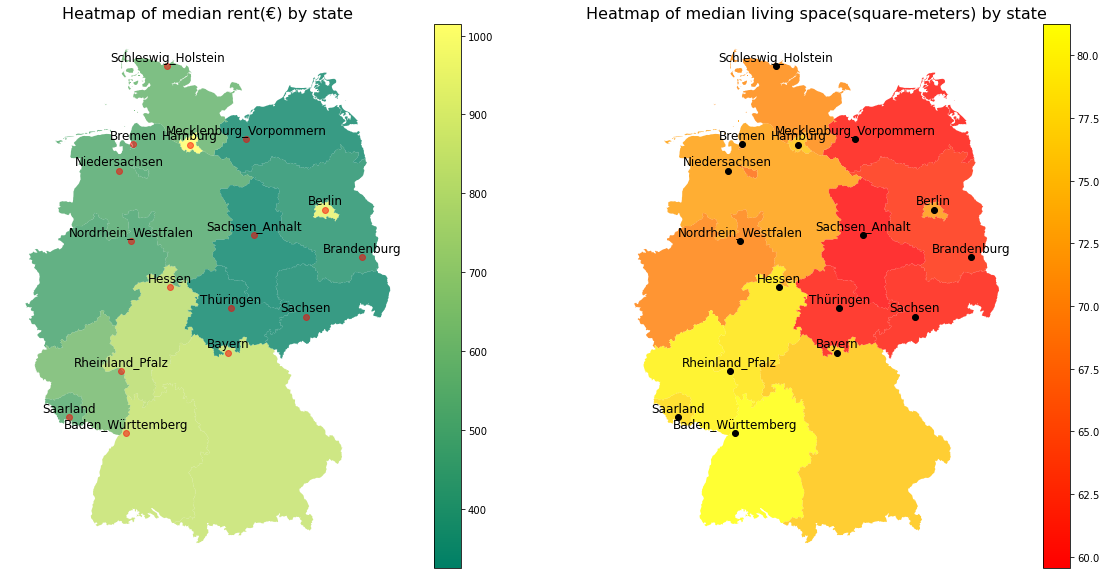

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
state_metrics_shapes[['state','geometry', 'medianBaseRent_state']].plot(
    ax=ax1, 
    column= 'medianBaseRent_state', 
    categorical=False, 
    legend=True, 
    cmap='summer',
    alpha=0.8
)

for state in state_location_dict.keys():

    ax1.text(
        x=state_location_dict[state][0], 
        y=state_location_dict[state][1] + 0.09, 
        s=state, 
        fontsize=12,
        ha='center', 
    )

    ax1.plot(
        state_location_dict[state][0], 
        state_location_dict[state][1], 
        marker='o',
        c='red', 
        alpha=0.5
    )

ax1.set_title('Heatmap of median rent(€) by state', fontdict = {'fontsize': 16})
ax1.axis('off')

state_metrics_shapes[['state','geometry', 'medianLivingSpace_state']].plot(
    ax=ax2, 
    column= 'medianLivingSpace_state', 
    categorical=False, 
    legend=True, 
    cmap='autumn',
    alpha=0.8
)

for state in state_location_dict.keys():

    ax2.text(
        x=state_location_dict[state][0], 
        y=state_location_dict[state][1] + 0.09, 
        s=state, 
        fontsize=12,
        ha='center', 
    )

    ax2.plot(
        state_location_dict[state][0], 
        state_location_dict[state][1], 
        marker='o',
        c='black', 
    )

ax2.set_title('Heatmap of median living space(square-meters) by state', fontdict = {'fontsize': 16})
ax2.axis('off')
plt.savefig('../reports/figures/map.png', bbox_inches="tight");

# Relationship between base rent and total number of cities / towns per state

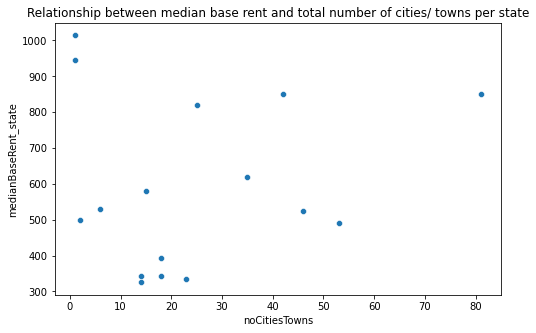

In [26]:
#Plot relationship between median base rent and total number of cities/towns per state
plt.figure(figsize = (8, 5))
plt.title('Relationship between median base rent and total number of cities/ towns per state')
sns.scatterplot(data = state_summary, x = 'noCitiesTowns', y = 'medianBaseRent_state');

There is no clear pattern between the number of cities/towns in a state and the median base rent.

# Relationship between base rent and total number of municipalities per state and city/town

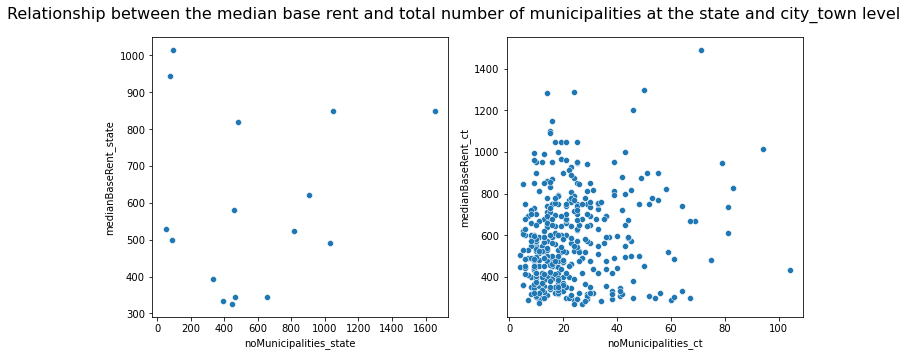

In [27]:
# Plot median base rent versus total number of zip codes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
fig = plt.gcf()
fig.suptitle("Relationship between the median base rent and total number of municipalities at the state and city_town level", fontsize = 16)
sns.scatterplot(data = state_summary, x = 'noMunicipalities_state' , y = 'medianBaseRent_state', ax = ax1)
sns.scatterplot(data = city_town_summary, x = 'noMunicipalities_ct' , y = 'medianBaseRent_ct', ax = ax2)
plt.tight_layout();

There no clear relationship between the median base rent and the total number of municipalities per state; however, we observe the slight positive relationship between the median base rent and total number of municipalities per city/town.

# Relationship between base rent and total number of zip codes per state, city/town and municipality

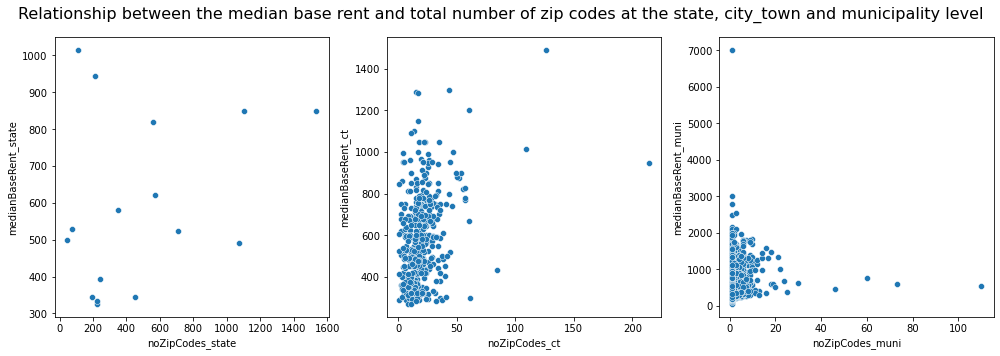

In [28]:
# Plot median base rent versus total number of zip codes
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (14, 5))
fig = plt.gcf()
fig.suptitle("Relationship between the median base rent and total number of zip codes at the state, city_town and municipality level", fontsize = 16)
sns.scatterplot(data = state_summary, x = 'noZipCodes_state' , y = 'medianBaseRent_state', ax = ax1)
sns.scatterplot(data = city_town_summary, x = 'noZipCodes_ct' , y = 'medianBaseRent_ct', ax = ax2)
sns.scatterplot(data = municipality_summary, x = 'noZipCodes_muni' , y = 'medianBaseRent_muni', ax = ax3)
plt.tight_layout();

There is no clear relationship between the median base rent and the total number of zip codes per state, city/town, or municipality.

# Relationship between base rent and total number of listings per state, city/town, municipality and zip code

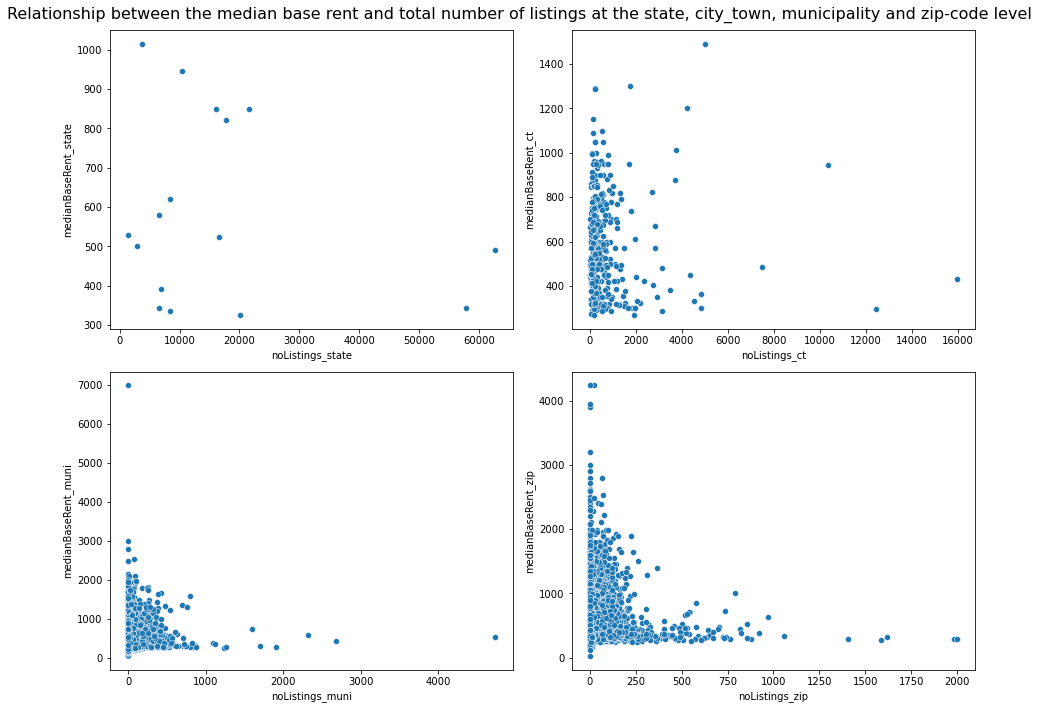

In [29]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (13, 10))
fig = plt.gcf()
fig.suptitle("Relationship between the median base rent and total number of listings at the state, city_town, municipality and zip-code level", fontsize = 16)
sns.scatterplot(data = state_summary, x = 'noListings_state' , y = 'medianBaseRent_state', ax = ax1)
sns.scatterplot(data = city_town_summary, x = 'noListings_ct' , y = 'medianBaseRent_ct', ax = ax2)
sns.scatterplot(data = municipality_summary, x = 'noListings_muni' , y = 'medianBaseRent_muni', ax = ax3)
sns.scatterplot(data = zip_code_summary, x = 'noListings_zip' , y = 'medianBaseRent_zip', ax = ax4)
plt.tight_layout();

There is no clearn relationship between median base rent and the total number of listings per state, city/town, municipality, or zip code.

# Relationship between base rent and total number of rooms

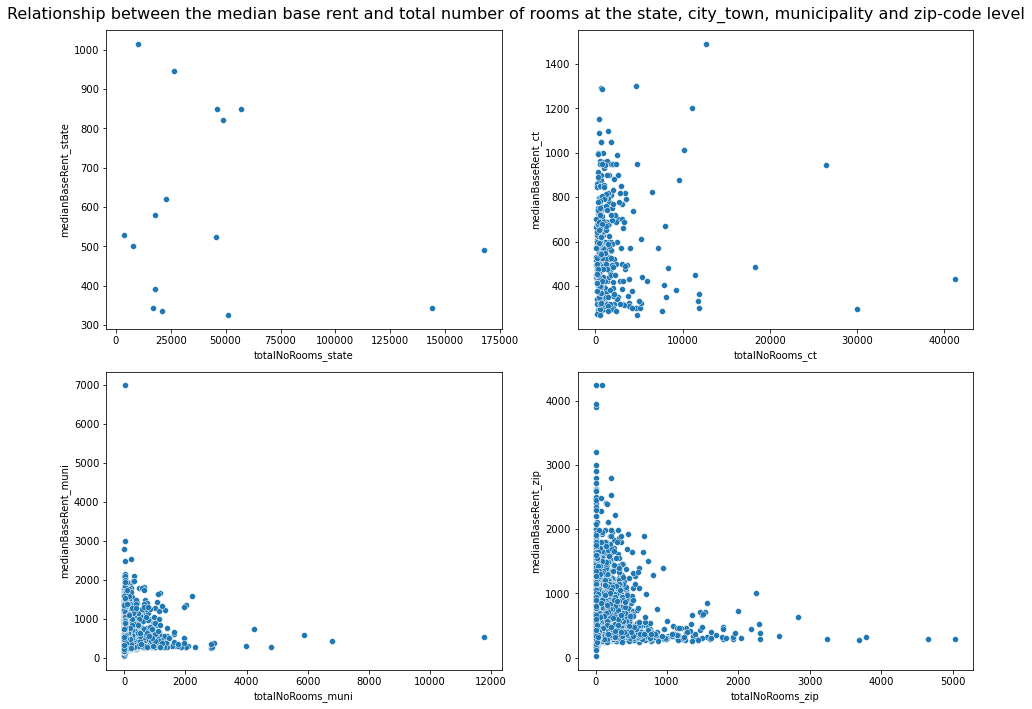

In [30]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (13, 10))
fig = plt.gcf()
fig.suptitle("Relationship between the median base rent and total number of rooms at the state, city_town, municipality and zip-code level", fontsize = 16)
sns.scatterplot(data = state_summary, x = 'totalNoRooms_state' , y = 'medianBaseRent_state', ax = ax1)
sns.scatterplot(data = city_town_summary, x = 'totalNoRooms_ct' , y = 'medianBaseRent_ct', ax = ax2)
sns.scatterplot(data = municipality_summary, x = 'totalNoRooms_muni' , y = 'medianBaseRent_muni', ax = ax3)
sns.scatterplot(data = zip_code_summary, x = 'totalNoRooms_zip' , y = 'medianBaseRent_zip', ax = ax4)
plt.tight_layout();

We observe no clear patterns in the relationship between median base rents and the total number of rooms in the state, city/town, municipality, or zip code.

# Relationship between base rent and the total living area

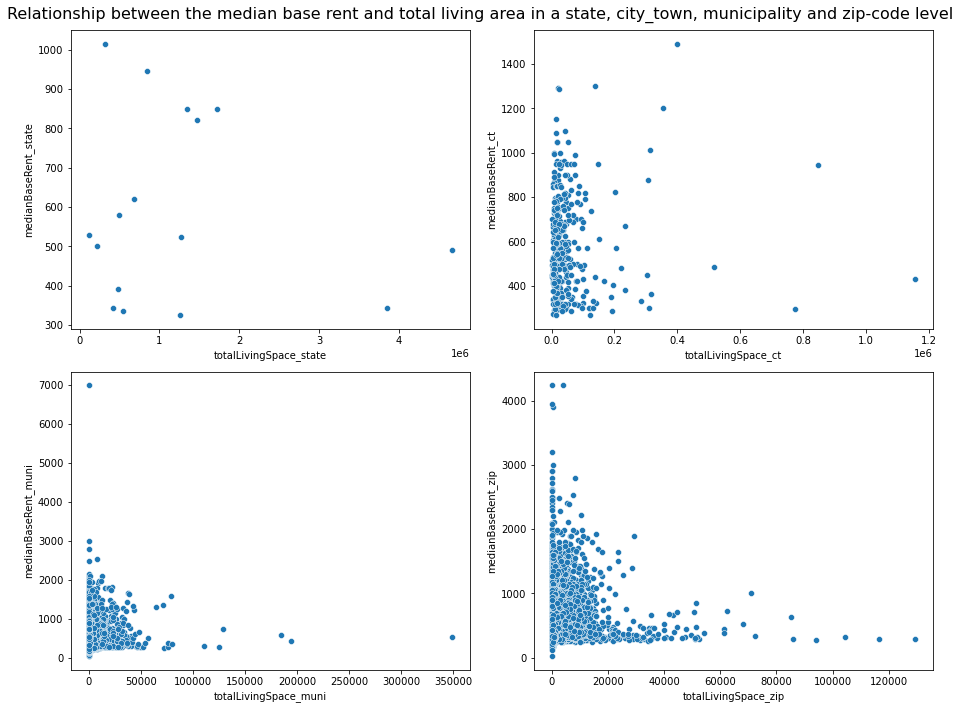

In [31]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (13, 10))
fig = plt.gcf()
fig.suptitle("Relationship between the median base rent and total living area in a state, city_town, municipality and zip-code level", fontsize = 16)
sns.scatterplot(data = state_summary, x = 'totalLivingSpace_state' , y = 'medianBaseRent_state', ax = ax1)
sns.scatterplot(data = city_town_summary, x = 'totalLivingSpace_ct' , y = 'medianBaseRent_ct', ax = ax2)
sns.scatterplot(data = municipality_summary, x = 'totalLivingSpace_muni' , y = 'medianBaseRent_muni', ax = ax3)
sns.scatterplot(data = zip_code_summary, x = 'totalLivingSpace_zip' , y = 'medianBaseRent_zip', ax = ax4)
plt.tight_layout();

Similar to the relationship between the median base rent and the total number of rooms, we do not observe a pattern in the relationship between the median base rent and total number of rooms in a state, city/town, municipality, or municipality.

# Relationship between base rent and number of rooms

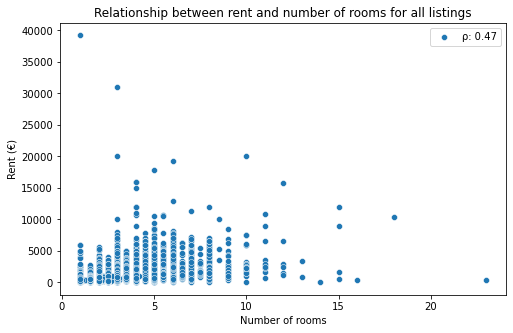

In [32]:
#Plot relationship between base rent and number of rooms for all listings
plt.figure(figsize = (8, 5))
base_rent_corr = stats.spearmanr(rentals.noRooms, rentals.baseRent, nan_policy = 'omit')[0]
sns.scatterplot(data = rentals, x = 'noRooms', y = 'baseRent', label = f'ρ: {base_rent_corr:.2f}');
plt.title('Relationship between rent and number of rooms for all listings')
plt.xlabel('Number of rooms')
plt.ylabel('Rent (€)')
plt.legend()
plt.savefig('../reports/figures/noRooms_rent.png', bbox_inches="tight");

The relationship between base rent and the number of rooms is not clear when all listings are considered, but there seems to be a slightly positive pattern. 

In [33]:
def numericalplot(target, feature, adjust_fig, *args, **kwargs):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = adjust_fig)
    feature_label = kwargs.get('feature_label', '')
    #axis = kwargs.get('axis', '')
    locations = ['state', 'city_town', 'municipality', 'zip_code']
    location_dfs = [state_summary, city_town_summary, municipality_summary, zip_code_summary]
    abbrs = ['state', 'ct', 'muni', 'zip']
    axes = [ax1, ax2, ax3, ax4]
    locations_abbrs = zip(locations,location_dfs, abbrs, axes)
    for location, location_df, abbr, ax in locations_abbrs:           
        ax_corr = stats.spearmanr(location_df[f'median{feature}_{abbr}'], location_df[f'median{target}_{abbr}'], nan_policy = 'omit')[0]
        sns.scatterplot(data = location_df, x = f'median{feature}_{abbr}', y = f'median{target}_{abbr}', label = f'ρ: {ax_corr:.2f}', ax = ax)
        ax.legend()
        #ax.set_title(f'Median {location} rent vs. {feature}')
        ax.set_ylabel(f'Median {location} rent (€)')
        ax.set_xlabel(f'Median {location} {feature} {feature_label}')
    plt.tight_layout()
    plt.savefig(f'../reports/figures/{feature}_rent_all.png', bbox_inches="tight");

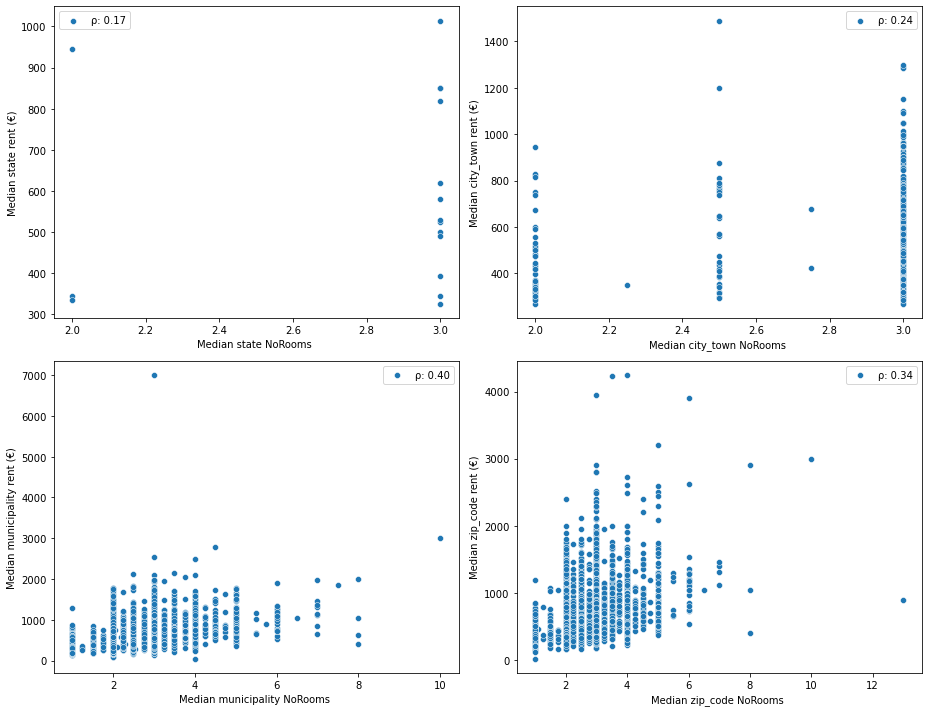

In [34]:
numericalplot('BaseRent', 'NoRooms', adjust_fig = (13, 10));

We observe a linear relationship between the median number of rooms at the municipality and zip-code level. The relationship is more pronounced at the municipality level; however, this relationship is muted at the state level. At the state-level, the variation in the median number of rooms is minimal, which results in the absence of a clear relationship.

# Relationship between base rent and living area

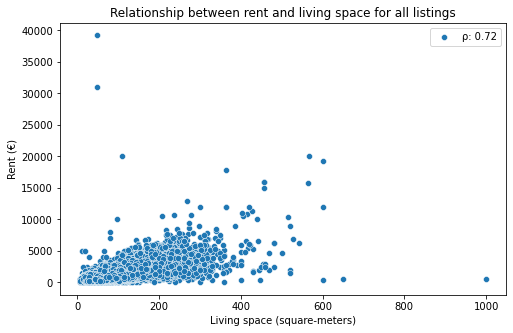

In [35]:
#Plot relationship between base rent and living area for all listings
plt.figure(figsize = (8, 5))
plt.title('Relationship between rent and living space for all listings')
space_rent_corr = stats.spearmanr(rentals.livingSpace, rentals.baseRent, nan_policy = 'omit')[0]
sns.scatterplot(data = rentals, x = 'livingSpace', y = 'baseRent', label = f'ρ: {space_rent_corr:.2f}')
plt.title('Relationship between rent and living space for all listings')
plt.xlabel('Living space (square-meters)')
plt.ylabel('Rent (€)')
plt.legend()
plt.savefig('../reports/figures/livingSpace_rent.png', bbox_inches="tight");

We observe a positive relationship between base rent and the living area when considering all listings.

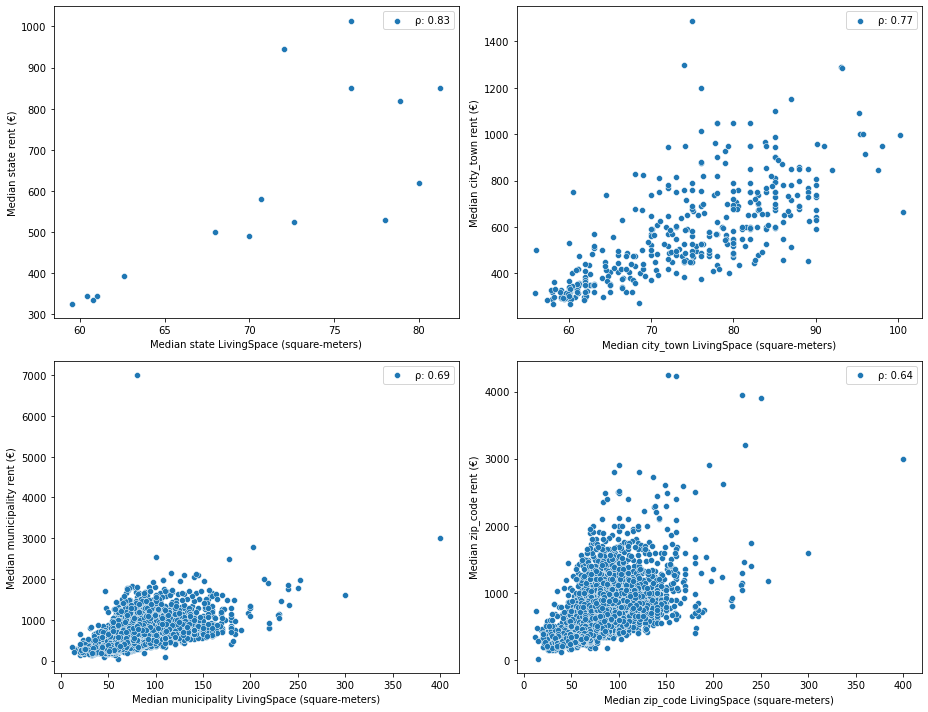

In [36]:
numericalplot('BaseRent', 'LivingSpace', adjust_fig = (13, 10), feature_label = '(square-meters)');

We observe a general positive relationship between the median living area of a property and median base rent at all levels.

# Relationship between base rent and service charge

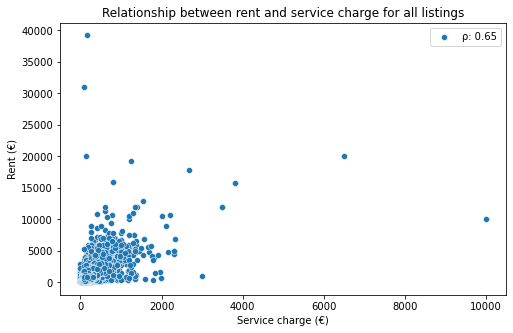

In [37]:
#Plot relationship between base rent and service charge for all listings
plt.figure(figsize = (8, 5))
plt.title('Relationship between rent and service charge for all listings')
ax_corr = stats.spearmanr(rentals.serviceCharge, rentals.baseRent, nan_policy = 'omit')[0]
sns.scatterplot(data = rentals, x = 'serviceCharge', y = 'baseRent', label = f'ρ: {ax_corr:.2f}')
plt.legend()
plt.ylabel('Rent (€)')
plt.xlabel('Service charge (€)')
plt.savefig('../reports/figures/service_rent.png', bbox_inches="tight");

Most of the values are congregated at the lower left-hand-corner of the plot, but we can observe a positive oriented tilt, suggesting a positive relationship between base rent and service charge.

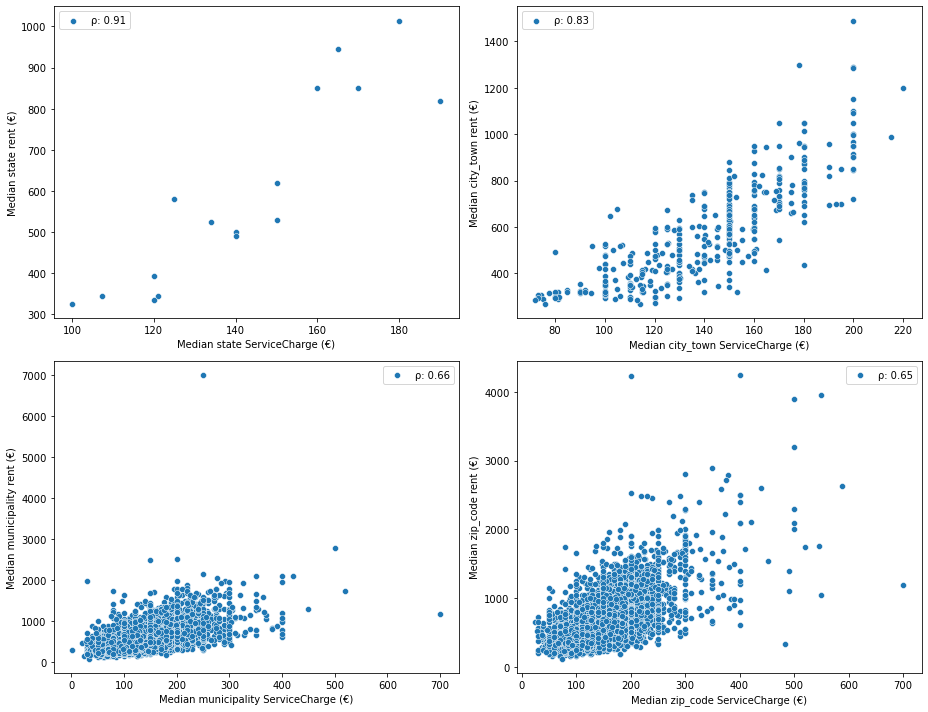

In [38]:
numericalplot('BaseRent', 'ServiceCharge', adjust_fig = (13, 10), feature_label = '(€)')

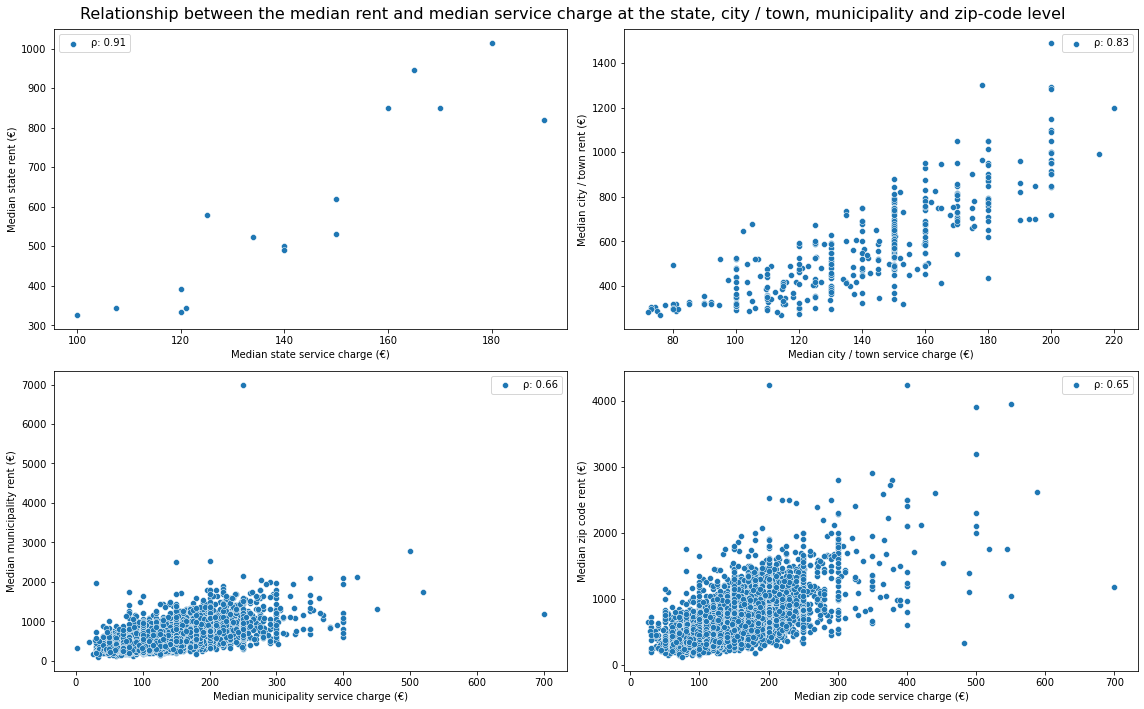

In [39]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (16, 10))
fig = plt.gcf()
fig.suptitle("Relationship between the median rent and median service charge at the state, city / town, municipality and zip-code level", fontsize = 16)
ax1_corr = stats.spearmanr(state_summary.medianServiceCharge_state, state_summary.medianBaseRent_state)[0]
sns.scatterplot(data = state_summary, x = 'medianServiceCharge_state' , y = 'medianBaseRent_state', ax = ax1, label = f'ρ: {ax1_corr:.2f}')
ax1.legend()
ax1.set_ylabel('Median state rent (€)')
ax1.set_xlabel('Median state service charge (€)')
ax2_corr = stats.spearmanr(city_town_summary.medianServiceCharge_ct, city_town_summary.medianBaseRent_ct)[0]
sns.scatterplot(data = city_town_summary, x = 'medianServiceCharge_ct' , y = 'medianBaseRent_ct', ax = ax2, label = f'ρ: {ax2_corr:.2f}')
ax2.legend()
ax2.set_ylabel('Median city / town rent (€)')
ax2.set_xlabel('Median city / town service charge (€)')
ax3_corr = stats.spearmanr(municipality_summary.medianServiceCharge_muni, municipality_summary.medianBaseRent_muni, nan_policy = 'omit')[0]
sns.scatterplot(data = municipality_summary, x = 'medianServiceCharge_muni' , y = 'medianBaseRent_muni', ax = ax3, label = f'ρ: {ax3_corr:.2f}')
ax3.legend()
ax3.set_ylabel('Median municipality rent (€)')
ax3.set_xlabel('Median municipality service charge (€)')
ax4_corr = stats.spearmanr(zip_code_summary.medianServiceCharge_zip, zip_code_summary.medianBaseRent_zip, nan_policy = 'omit')[0]
sns.scatterplot(data = zip_code_summary, x = 'medianServiceCharge_zip' , y = 'medianBaseRent_zip', ax = ax4, label = f'ρ: {ax4_corr:.2f}')
ax4.legend()
ax4.set_ylabel('Median zip code rent (€)')
ax4.set_xlabel('Median zip code service charge (€)')
plt.savefig('../reports/figures/service_rent_all.png', bbox_inches="tight");
plt.tight_layout();

The positive relationship we observed between median base rent and the median service charge for all listings is more pronounce at the state, municipality and zip_code level.

# Relationship between base rent and heating cost

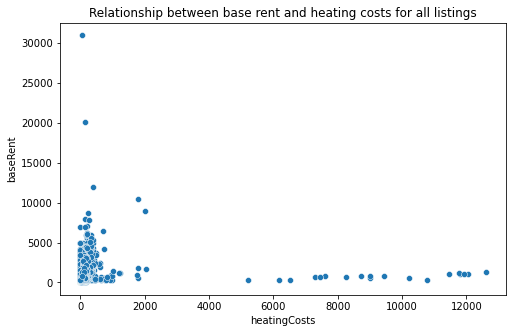

In [40]:
#Plot relationship between base rent and heating costs for all listings
plt.figure(figsize = (8, 5))
plt.title('Relationship between base rent and heating costs for all listings')
sns.scatterplot(data = rentals, x = 'heatingCosts', y = 'baseRent');

There is no clear trend between base rent and heating cost when we consider all listings. 

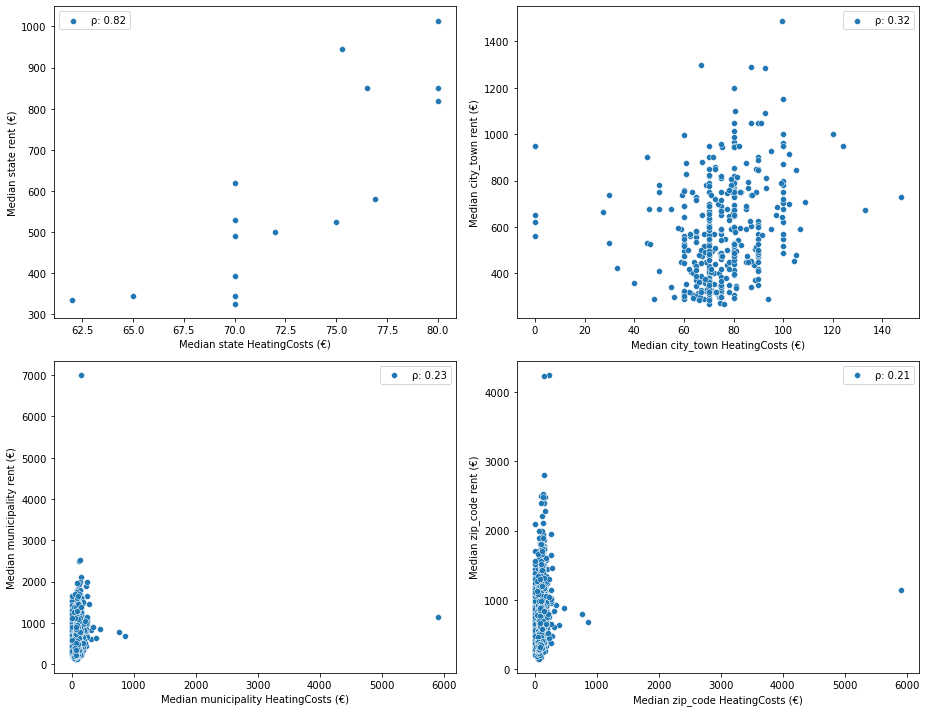

In [41]:
numericalplot('BaseRent', 'HeatingCosts', adjust_fig = (13, 10), feature_label = '(€)')

We observe a positive relationship between the median base rent and median heating costs at the state-level, but not at the municipality or zip-code level.

# Relationship between base rent and internet upload speed

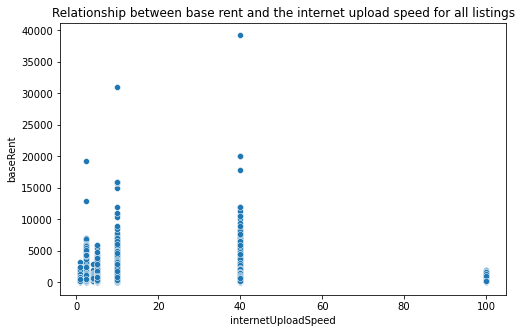

In [42]:
#Plot relationship between base rent and the internet upload speed for all listings
plt.figure(figsize = (8, 5))
plt.title('Relationship between base rent and the internet upload speed for all listings')
sns.scatterplot(data = rentals, x = 'internetUploadSpeed', y = 'baseRent');

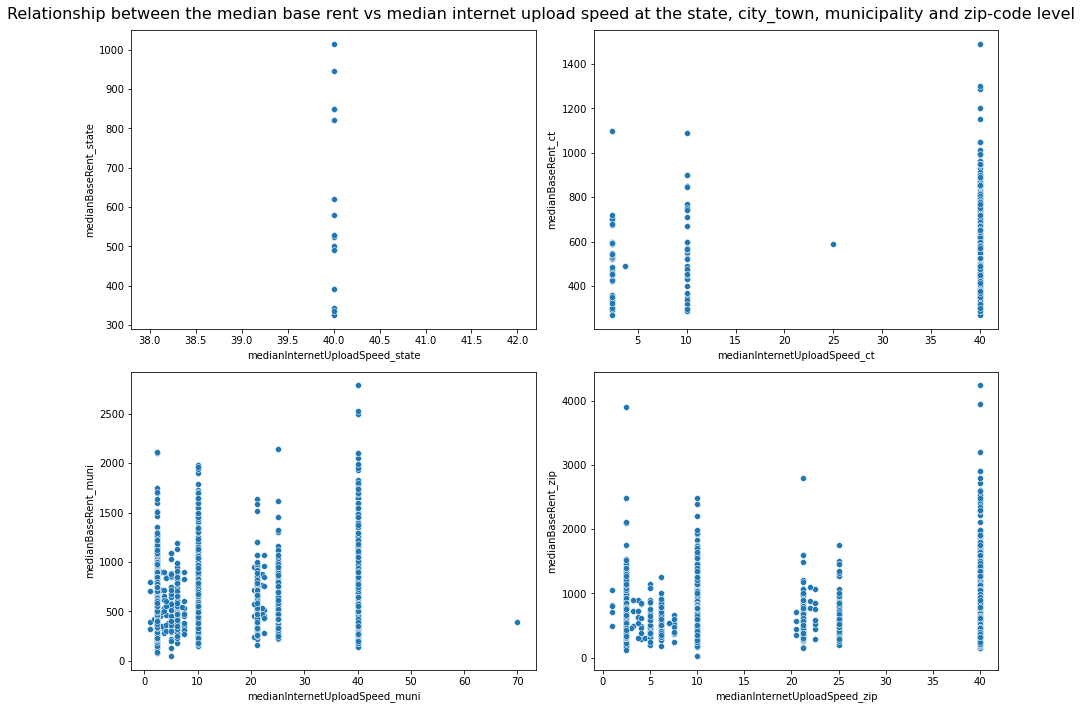

In [43]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (13, 10))
fig = plt.gcf()
fig.suptitle("Relationship between the median base rent vs median internet upload speed at the state, city_town, municipality and zip-code level", fontsize = 16)
sns.scatterplot(data = state_summary, x = 'medianInternetUploadSpeed_state' , y = 'medianBaseRent_state', ax = ax1)
sns.scatterplot(data = city_town_summary, x = 'medianInternetUploadSpeed_ct' , y = 'medianBaseRent_ct', ax = ax2)
sns.scatterplot(data = municipality_summary, x = 'medianInternetUploadSpeed_muni' , y = 'medianBaseRent_muni', ax = ax3)
sns.scatterplot(data = zip_code_summary, x = 'medianInternetUploadSpeed_zip' , y = 'medianBaseRent_zip', ax = ax4)
plt.tight_layout();

There is no variation of base rent with the internet upload speed at the state level. We do not observe a relationship between the base rent and internet upload speed at either the city, municipality or zip-code level.

# Relationship between base rent and thermalChar

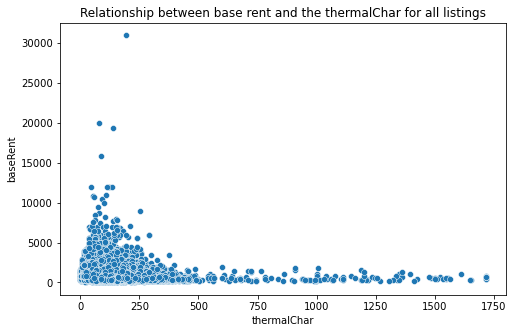

In [44]:
#Plot relationship between base rent and the internet upload speed for all listings
plt.figure(figsize = (8, 5))
plt.title('Relationship between base rent and the thermalChar for all listings')
sns.scatterplot(data = rentals, x = 'thermalChar', y = 'baseRent');

We don't observe a relationship between base rent and thermal char when all listings are considered.

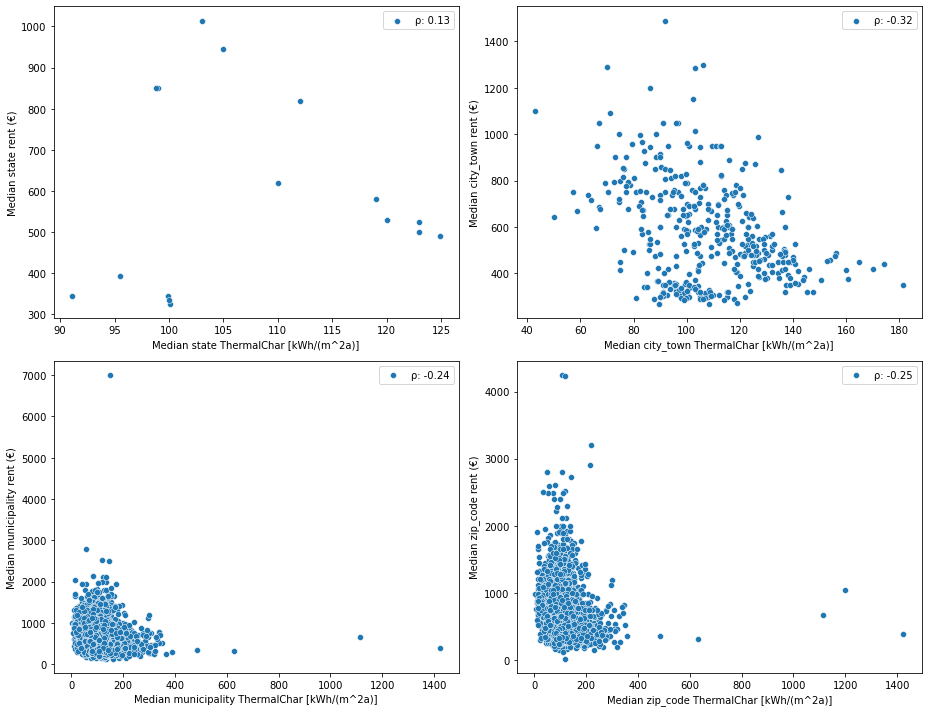

In [45]:
numericalplot('BaseRent', 'ThermalChar', adjust_fig = (13, 10), feature_label = '[kWh/(m^2a)]')

These plots further confirm the opacity of a relationship between base rent and thermal char at all levels of aggregation.

# Relationship between base rent and number of floors

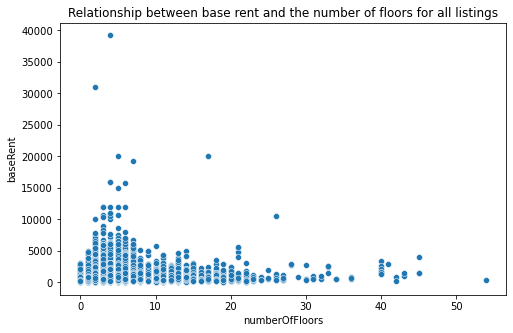

In [46]:
#Plot relationship between base rent and the number of floors for all listings
plt.figure(figsize = (8, 5))
plt.title('Relationship between base rent and the number of floors for all listings')
sns.scatterplot(data = rentals, x = 'numberOfFloors', y = 'baseRent');

We do not see a clear relationship between the base rent and the number of floors in a property. 

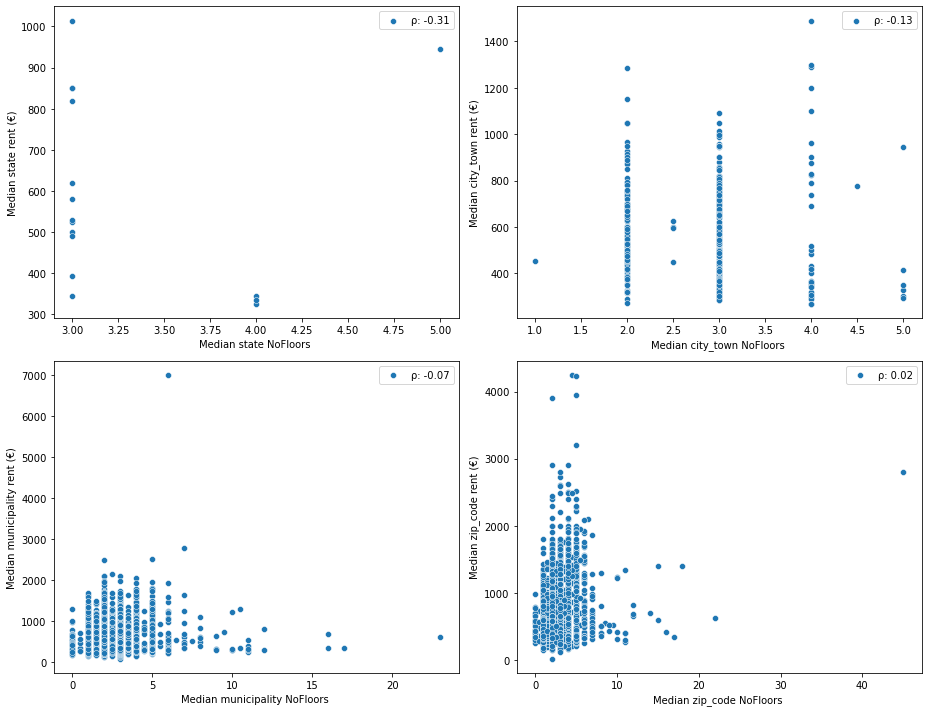

In [47]:
numericalplot('BaseRent', 'NoFloors', adjust_fig = (13, 10))

These plots affirm our intuition about the lack of a clear relationship between base rent and the number of floors of a property.

# Relationship between base rent and floor number

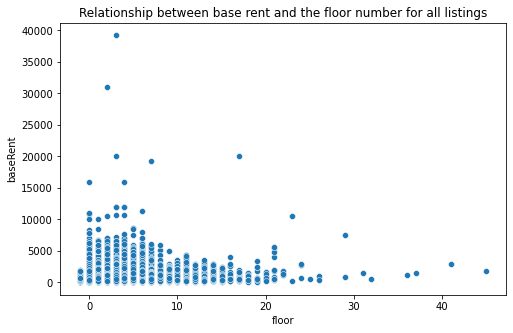

In [48]:
#Plot relationship between base rent and the floor number for all listings
plt.figure(figsize = (8, 5))
plt.title('Relationship between base rent and the floor number for all listings')
sns.scatterplot(data = rentals, x = 'floor', y = 'baseRent');

We do not observe a clear relationship between the base rent and the floor number of a property.

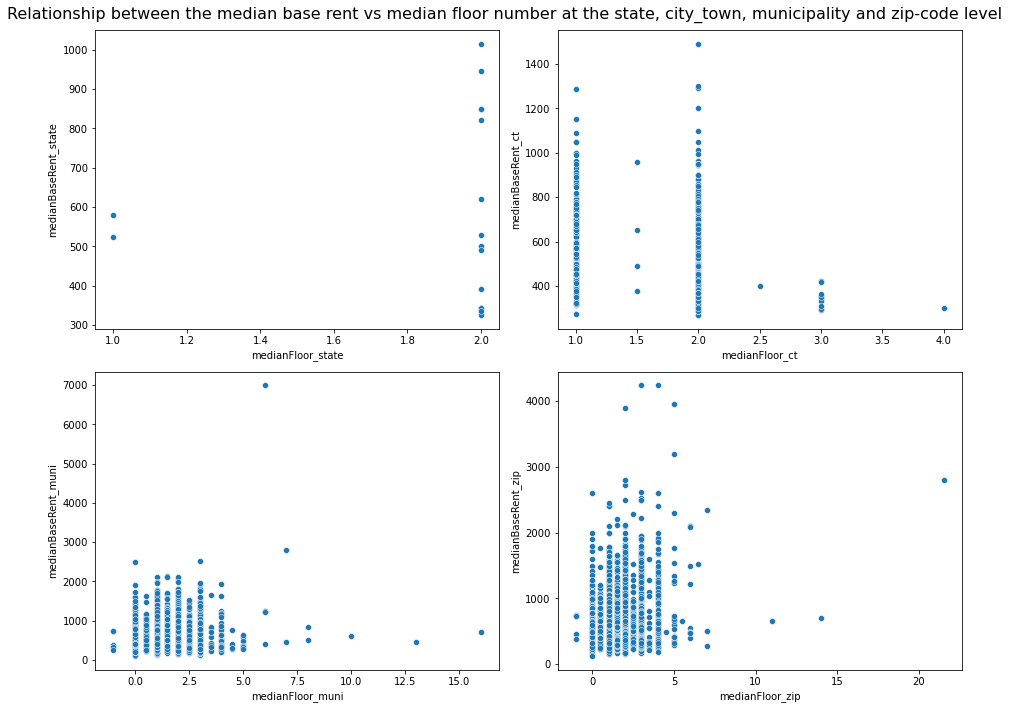

In [49]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (13, 10))
fig = plt.gcf()
fig.suptitle("Relationship between the median base rent vs median floor number at the state, city_town, municipality and zip-code level", fontsize = 16)
sns.scatterplot(data = state_summary, x = 'medianFloor_state' , y = 'medianBaseRent_state', ax = ax1)
sns.scatterplot(data = city_town_summary, x = 'medianFloor_ct' , y = 'medianBaseRent_ct', ax = ax2)
sns.scatterplot(data = municipality_summary, x = 'medianFloor_muni' , y = 'medianBaseRent_muni', ax = ax3)
sns.scatterplot(data = zip_code_summary, x = 'medianFloor_zip' , y = 'medianBaseRent_zip', ax = ax4)
plt.tight_layout();

These plots affirm our suspicion of the lack of a relationship between the base rent and floor number of a property.

# Relationship between base rent and number of pictures on listing

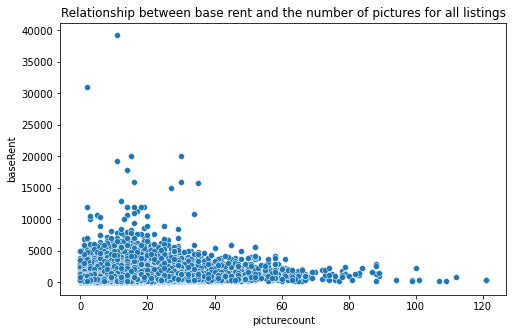

In [50]:
#Plot relationship between base rent and the number of pictures posted for all listings
plt.figure(figsize = (8, 5))
plt.title('Relationship between base rent and the number of pictures for all listings')
sns.scatterplot(data = rentals, x = 'picturecount', y = 'baseRent');

We do not observe a clear relationship between the base rent and the number of pictures posted on the property listing.

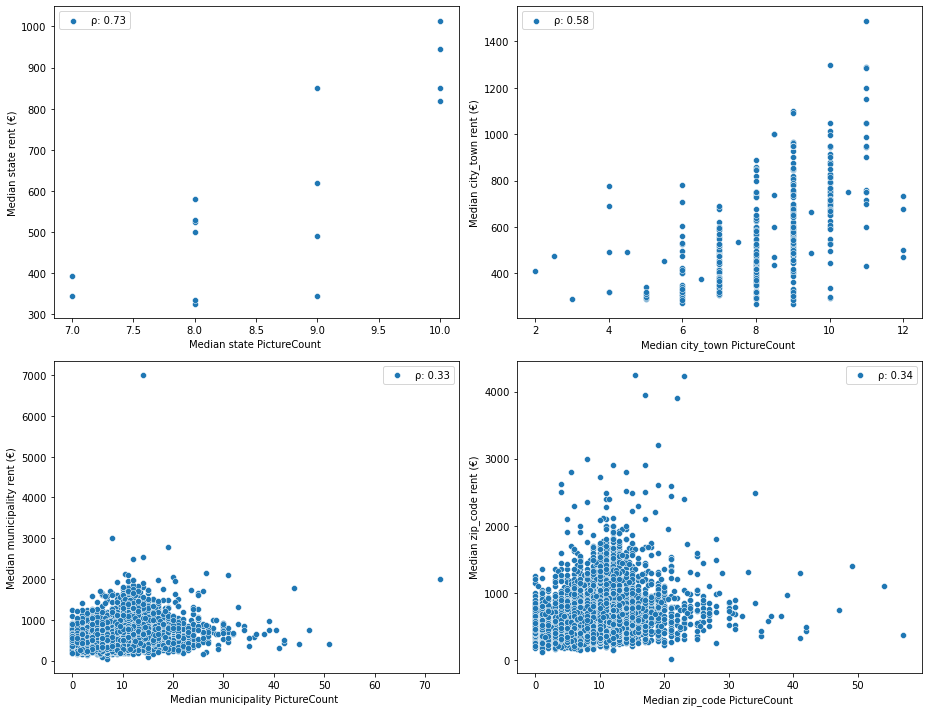

In [51]:
numericalplot('BaseRent', 'PictureCount', adjust_fig = (13, 10))

Similar to the total listings perspective, we do not observe a relationship between the picture count and the base rent at the aggregate levels of the state, city/town, municipality or zip code.

# Relationship between base rent and categorical features

## Box plot of base rents for each state

In [52]:
state_order = list(rentals.groupby('state')['baseRent'].median().sort_values(ascending = True).index)

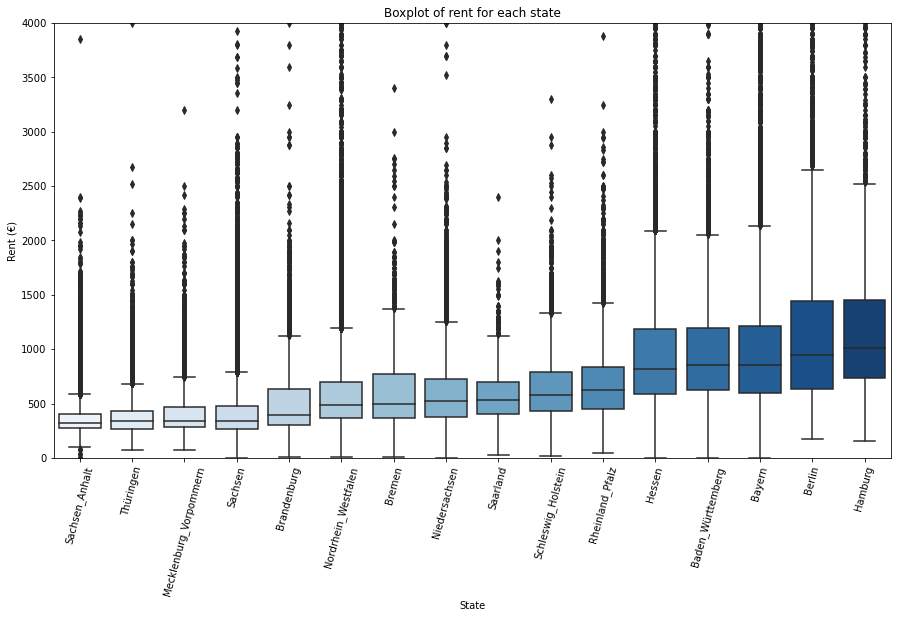

In [53]:
fig, ax = plt.subplots(figsize = (15, 8))
sns.boxplot(data = rentals, y = 'baseRent', x = 'state', order = state_order, palette = 'Blues')
plt.title('Boxplot of rent for each state')
plt.ylabel('Rent (€)')
plt.ylim([0, 4000])
plt.xlabel('State')
plt.tick_params(axis='x', labelrotation= 75)
plt.savefig('../reports/figures/state_rents.png', bbox_inches="tight");

We observe that base rent varies with the state, with Hamburg, Berlin, Baden Wurttemberg, Bayern and Hessen being the most expensive states to live in Germany, while Mecklenburg Vorpommen, Sachsen, Thuringen and Sachsen Anhalt are the least expensive states to live in Germany. 

### Most expensive cities / towns

In [54]:
rentals.groupby(['city_town', 'state'])['baseRent'].median().sort_values(ascending = False)[:10]

city_town             state            
München               Bayern               1490.0
Stuttgart             Baden_Württemberg    1300.0
Freiburg_im_Breisgau  Baden_Württemberg    1290.0
Starnberg             Bayern               1285.0
Frankfurt_am_Main     Hessen               1200.0
Miesbach              Bayern               1150.0
Heidelberg            Baden_Württemberg    1100.0
Lindau_Bodensee       Bayern               1090.0
Dachau                Bayern               1050.0
Fürstenfeldbruck      Bayern               1050.0
Name: baseRent, dtype: float64

In [55]:
most_expensive_cities_towns = pd.DataFrame(city_town_summary['medianBaseRent_ct'].sort_values(ascending = False)[:10]).reset_index()
least_expensive_cities_towns = pd.DataFrame(city_town_summary['medianBaseRent_ct'].sort_values(ascending = True)[:10]).reset_index()

### Least expensive cities / towns

In [56]:
rentals.groupby(['city_town', 'state'])['baseRent'].median().sort_values(ascending = True)[:10]
#plt.tick_params(axis='x', labelrotation= 80)

city_town          state                 
Plauen             Sachsen                   268.00
Uecker_Randow      Mecklenburg_Vorpommern    270.00
Lüchow_Dannenberg  Niedersachsen             274.50
Vogtlandkreis      Sachsen                   285.00
Wittenberg         Sachsen_Anhalt            285.00
Mittelsachsen      Sachsen                   289.00
Kyffhäuserkreis    Thüringen                 290.00
Hoyerswerda        Sachsen                   290.00
Greiz              Thüringen                 290.50
Demmin             Mecklenburg_Vorpommern    293.37
Name: baseRent, dtype: float64

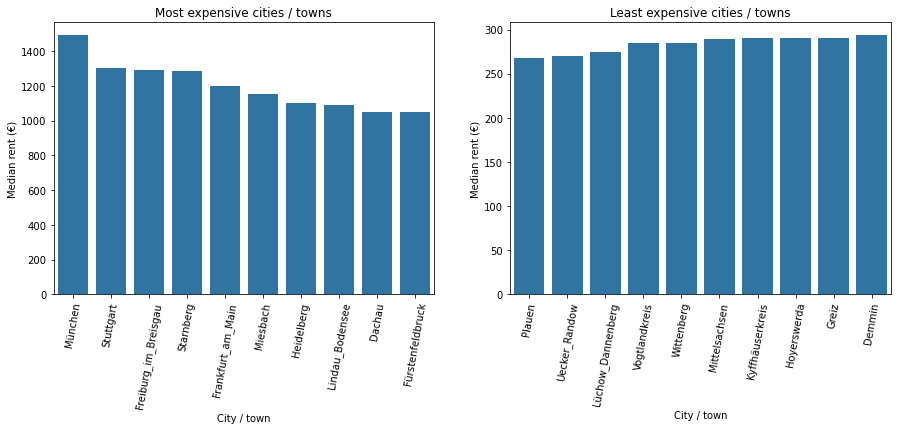

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
sns.barplot(data = most_expensive_cities_towns, x = 'city_town', y = 'medianBaseRent_ct', ax = ax1, color = 'C0')
ax1.set_title('Most expensive cities / towns')
ax1.set_xlabel('City / town')
ax1.set_ylabel('Median rent (€)')
ax1.tick_params(axis='x', labelrotation= 80)
sns.barplot(data = least_expensive_cities_towns, x = 'city_town', y = 'medianBaseRent_ct', ax = ax2, color = 'C0')
ax2.set_title('Least expensive cities / towns')
ax2.set_xlabel('City / town')
ax2.set_ylabel('Median rent (€)')
ax2.tick_params(axis='x', labelrotation= 80)
plt.savefig('../reports/figures/city_rent.png', bbox_inches="tight");

### Most expensive municipalities

In [58]:
rentals.groupby(['municipality', 'city_town', 'state'])['baseRent'].median().sort_values(ascending = False)[:10]

municipality           city_town                state                 
Güssefeld              Altmarkkreis_Salzwedel   Sachsen_Anhalt            7000.0
Westheim               Weißenburg_Gunzenhausen  Bayern                    3000.0
Mönchfeld              Stuttgart                Baden_Württemberg         2790.0
Lehel                  München                  Bayern                    2530.0
Gatow_Spandau          Berlin                   Berlin                    2500.0
Diedrichshagen         Rostock                  Mecklenburg_Vorpommern    2288.0
Fischen_im_Allgäu      Oberallgäu               Bayern                    2145.0
Glattbach              Aschaffenburg            Bayern                    2112.5
Bentwisch              Bad_Doberan              Mecklenburg_Vorpommern    2100.0
Grunewald_Wilmersdorf  Berlin                   Berlin                    2100.0
Name: baseRent, dtype: float64

### Least expensive municipalities

In [59]:
rentals.groupby(['municipality', 'city_town', 'state'])['baseRent'].median().sort_values(ascending = True)[:10]

municipality          city_town                         state                 
Coldewei_Himmelreich  Wilhelmshaven                     Niedersachsen              45.00
Birkweiler            Südliche_Weinstraße               Rheinland_Pfalz            79.00
Lübs                  Uecker_Randow                     Mecklenburg_Vorpommern     91.80
Dettum                Wolfenbüttel                      Niedersachsen             130.00
Ahrenshagen_Daskow    Nordvorpommern                    Mecklenburg_Vorpommern    131.45
Rosenow               Demmin                            Mecklenburg_Vorpommern    136.00
Haslach               Kempten_Allgäu                    Bayern                    141.60
Ilmtal                Ilm                               Thüringen                 142.35
Rathen                Sächsische_Schweiz_Osterzgebirge  Sachsen                   150.00
Reichenbach           Saale_Holzland                    Thüringen                 150.00
Name: baseRent, dtype: float64

In [60]:
most_expensive_municipalities = pd.DataFrame(municipality_summary['medianBaseRent_muni'].sort_values(ascending = False)[:10]).reset_index()
least_expensive_municipalities = pd.DataFrame(municipality_summary['medianBaseRent_muni'].sort_values(ascending = True)[:10]).reset_index()

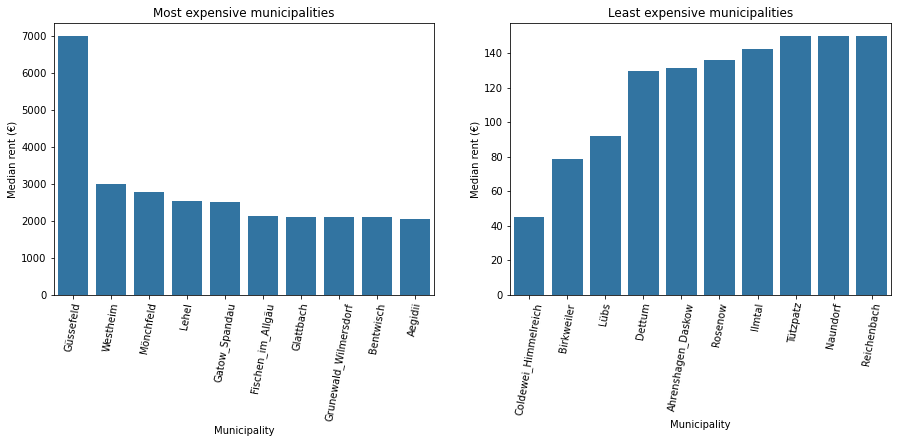

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
sns.barplot(data = most_expensive_municipalities, x = 'municipality', y = 'medianBaseRent_muni', ax = ax1, color = 'C0')
ax1.set_title('Most expensive municipalities')
ax1.set_xlabel('Municipality')
ax1.set_ylabel('Median rent (€)')
ax1.tick_params(axis='x', labelrotation= 80)
sns.barplot(data = least_expensive_municipalities, x = 'municipality', y = 'medianBaseRent_muni', ax = ax2, color = 'C0')
ax2.set_title('Least expensive municipalities')
ax2.set_xlabel('Municipality')
ax2.set_ylabel('Median rent (€)')
ax2.tick_params(axis='x', labelrotation= 80)
plt.savefig('../reports/figures/muni_rent.png', bbox_inches="tight");

### Most expensive zip codes

In [62]:
most_zip = pd.DataFrame(rentals.groupby(['zip_code', 'municipality', 'city_town', 'state'])['baseRent'].median().sort_values(ascending = False)[:10])
most_zip.head()

,,,,baseRent
zip_code,municipality,city_town,state,
4103,Lausen_Grünau,Leipzig,Sachsen,9000.0
39624,Güssefeld,Altmarkkreis_Salzwedel,Sachsen_Anhalt,7000.0
70191,Feuerbach,Stuttgart,Baden_Württemberg,5550.0
81679,Haidhausen,München,Bayern,5000.0
60322,Innenstadt,Frankfurt_am_Main,Hessen,4600.0


In [63]:
#Define zipcode and state as barplot labels
most_zip_labels = []
for zipcode, muni, city, state in most_zip.index:
    most_zip_labels.append((zipcode, state))

### Least expensive zip codes

In [64]:
least_zip = pd.DataFrame(rentals.groupby(['zip_code', 'municipality', 'city_town', 'state'])['baseRent'].median().sort_values(ascending = True)[:10])
least_zip.head()

,,,,baseRent
zip_code,municipality,city_town,state,
84387,Kirchdorf_am_Inn,Rottal_Inn,Bayern,18.5
84453,Polling,Mühldorf_am_Inn,Bayern,25.0
26388,Coldewei_Himmelreich,Wilhelmshaven,Niedersachsen,45.0
76831,Birkweiler,Südliche_Weinstraße,Rheinland_Pfalz,79.0
17379,Lübs,Uecker_Randow,Mecklenburg_Vorpommern,91.8


In [65]:
#Define zipcode and state for barplot labels
least_zip_labels = []
for zipcode, muni, city, state in least_zip.index:
    least_zip_labels.append((zipcode, state))

In [66]:
most_expensive_zip_codes = zip_code_summary.sort_values(by = 'medianBaseRent_zip', ascending = False)[:10]
least_expensive_zip_codes = zip_code_summary.sort_values(by = 'medianBaseRent_zip', ascending = True)[:10]

In [67]:
order_most = most_expensive_zip_codes
order_least = least_expensive_zip_codes

In [68]:
most_expensive_zip_codes.reset_index()

,zip_code,noListings_zip,totalNoRooms_zip,medianNoRooms_zip,medianLivingSpace_zip,totalLivingSpace_zip,medianServiceCharge_zip,medianInternetUploadSpeed_zip,medianBaseRent_zip,medianThermalChar_zip,medianFloor_zip,medianNoFloors_zip,medianHeatingCosts_zip,medianPictureCount_zip
0,80539,26,94.0,4.0,151.690,3943.85,400.0,40.0,4245.000,107.3,3.0,4.5,220.0,15.5
1,89538,1,3.5,3.5,160.000,160.00,200.0,NaN,4240.000,120.6,4.0,5.0,150.0,23.0
2,10577,1,3.0,3.0,230.000,230.00,550.0,40.0,3950.000,NaN,5.0,5.0,NaN,17.0
3,8382,1,6.0,6.0,250.000,250.00,500.0,2.4,3900.000,NaN,2.0,2.0,NaN,22.0
4,14053,1,5.0,5.0,233.000,233.00,500.0,40.0,3200.000,219.0,5.0,5.0,NaN,19.0
5,91747,1,10.0,10.0,400.000,400.00,NaN,NaN,3000.000,NaN,NaN,NaN,NaN,8.0
6,85561,1,8.0,8.0,195.000,195.00,350.0,40.0,2900.000,215.0,NaN,2.0,NaN,12.0
7,22148,1,3.0,3.0,100.000,100.00,NaN,40.0,2900.000,NaN,NaN,4.0,NaN,17.0
8,81679,65,210.0,3.0,121.000,8163.87,300.0,40.0,2800.000,108.9,2.0,3.0,140.0,14.0
9,60312,2,6.0,3.0,94.605,189.21,378.0,21.2,2797.495,51.1,21.5,45.0,NaN,5.5


In [69]:
#order_least

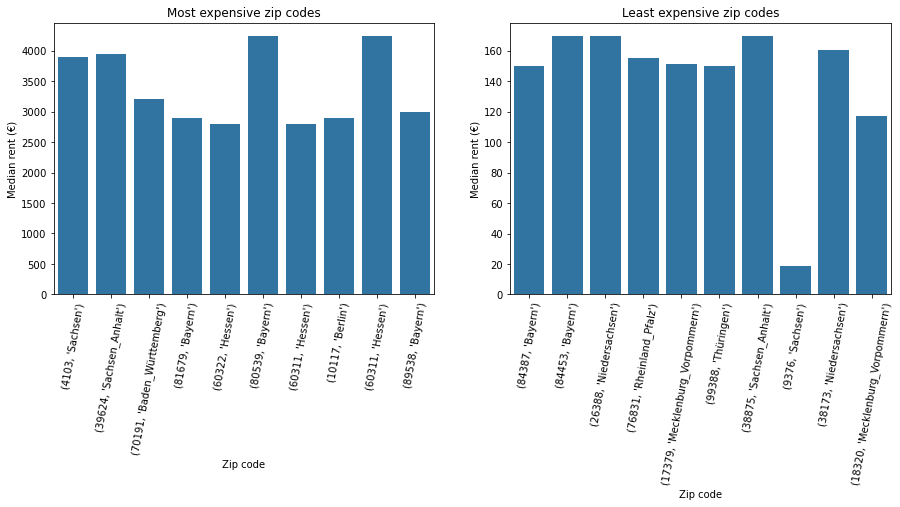

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
sns.barplot(data = most_expensive_zip_codes.reset_index(), x = 'zip_code', y = 'medianBaseRent_zip', ax = ax1, color = 'C0')
ax1.set_title('Most expensive zip codes')
ax1.set_xlabel('Zip code')
ax1.set_xticklabels(most_zip_labels)
ax1.tick_params(axis = 'x', labelrotation = 80)
ax1.set_ylabel('Median rent (€)')
sns.barplot(data = least_expensive_zip_codes.reset_index(), x = 'zip_code', y = 'medianBaseRent_zip', ax = ax2, color = 'C0')
ax2.set_title('Least expensive zip codes')
ax2.set_xlabel('Zip code')
#ax2.set_xticks(list(order_least.astype('string')))
ax2.set_xticklabels(least_zip_labels)
ax2.tick_params(axis = 'x', labelrotation = 80)
ax2.set_ylabel('Median rent (€)')
plt.savefig('../reports/figures/zip_rent.png', bbox_inches="tight");

## Box plot of base rents given the properties' interior quality

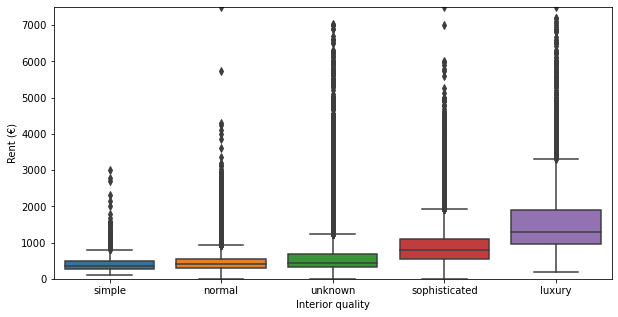

In [71]:
interiorQual_order = list(rentals.groupby('interiorQual')['baseRent'].median().sort_values(ascending = True).index)
plt.figure(figsize = (10, 5))
sns.boxplot(data = rentals, y = 'baseRent', x = 'interiorQual', order = interiorQual_order)
plt.ylim([0, 7500])
plt.xlabel('Interior quality')
plt.ylabel('Rent (€)')
plt.savefig('../reports/figures/qual_rent.png', bbox_inches="tight");

We that the base rent of luxury and sophisticated properties have higher median values, and most of their values are within the interquartile range when compared to the other categories (e.g. normal and simple apartments). 

## Box plot of base rents given the properties' condition

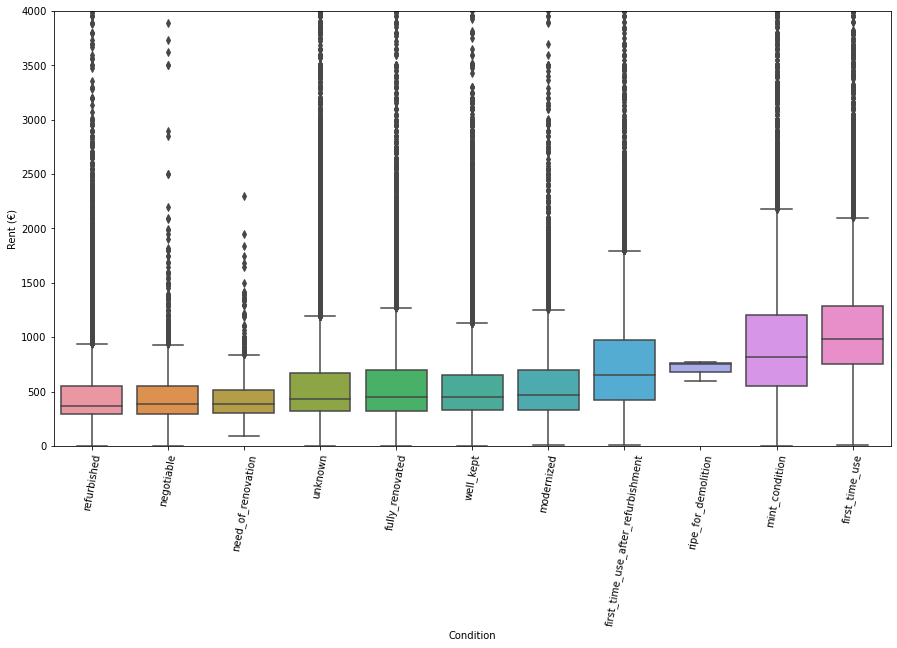

In [72]:
condition_order = list(rentals.groupby('condition')['baseRent'].median().sort_values(ascending = True).index)
plt.figure(figsize = (15, 8))
sns.boxplot(data = rentals, y = 'baseRent', x = 'condition', order = condition_order)
plt.ylim([0, 4000])
plt.xlabel('Condition')
plt.ylabel('Rent (€)')
plt.tick_params(axis = 'x', labelrotation = 80)
plt.savefig('../reports/figures/condition_rent.png', bbox_inches="tight");

We observe that first time properties and proerties in mint condition tend to command higher base rents.

## Box plot of base rents given the type of flat

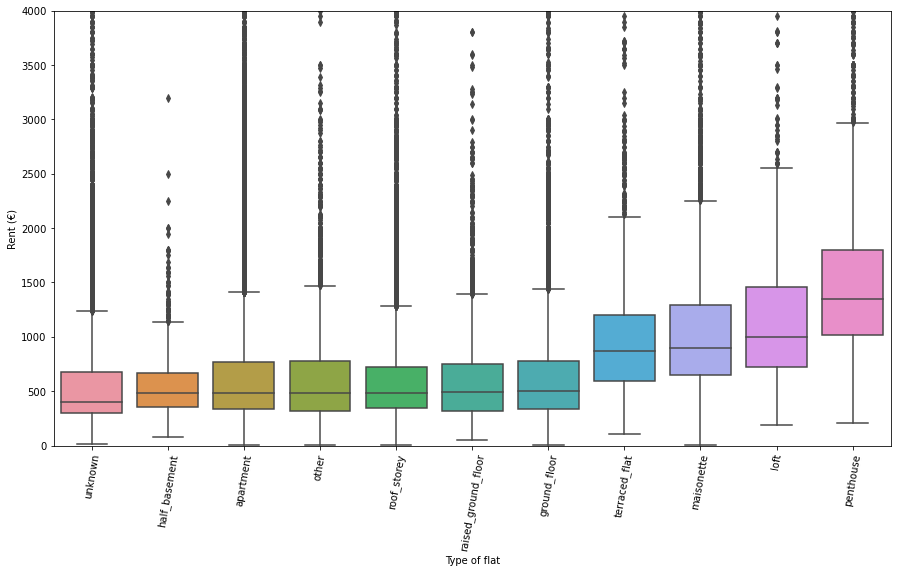

In [73]:
typeOfFlat_order = list(rentals.groupby('typeOfFlat')['baseRent'].median().sort_values(ascending = True).index)
plt.figure(figsize = (15, 8))
sns.boxplot(data = rentals, y = 'baseRent', x = 'typeOfFlat', order = typeOfFlat_order)
plt.ylim([0, 4000])
plt.xlabel('Type of flat')
plt.ylabel('Rent (€)')
plt.tick_params(axis = 'x', labelrotation = 80)
plt.savefig('../reports/figures/flat_rent.png', bbox_inches="tight");

We observe that pent houses, lofts, maisonettes and terraced flats command higher rents than the other types of flats. Half basements command the lowest rents.

## Box plot of base rents given the availablityof a tv offer

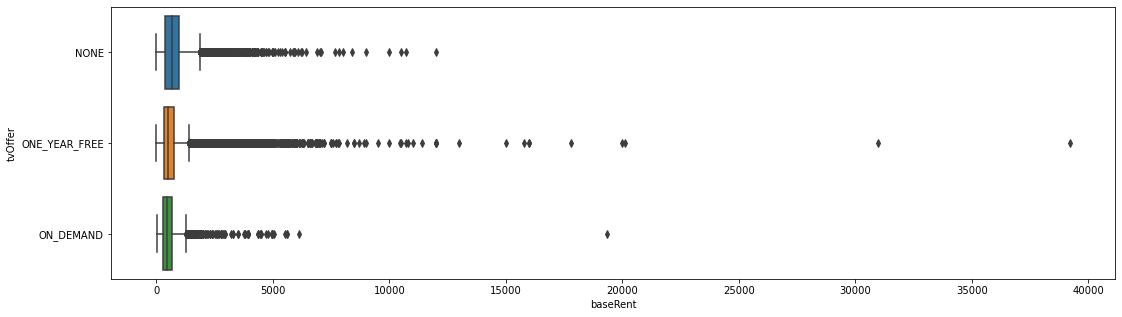

In [74]:
tvOffer_order = list(rentals.groupby('tvOffer')['baseRent'].median().sort_values(ascending = False).index)
plt.figure(figsize = (18, 5))
sns.boxplot(data = rentals, x= 'baseRent', y= 'tvOffer', order = tvOffer_order);

We do not observe much change in base rent with the tv offer incentive.

## Box plot of base rents given the allowance of a pet

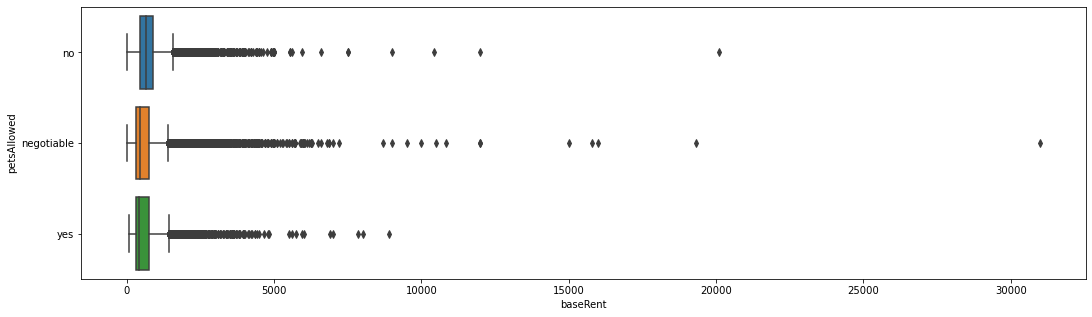

In [75]:
petsAllowed_order = list(rentals.groupby('petsAllowed')['baseRent'].median().sort_values(ascending = False).index)
plt.figure(figsize = (18, 5))
sns.boxplot(data = rentals, x = 'baseRent', y = 'petsAllowed', order = petsAllowed_order);

It is not clear that there is a significant difference in base rents between properties that do and do not allow pets. 

## Box plot of base rents given properties's are new or not new

In [76]:
#Replace true / false with yes / no for newlyConst
rentals.newlyConst = rentals.newlyConst.replace({True: 'Yes', False: 'No'})

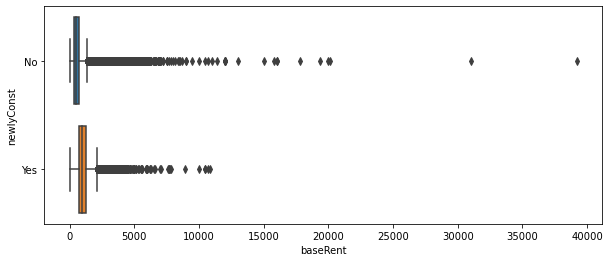

In [77]:
#Plot box plot of rentals versus whether the unit is a new construction
plt.figure(figsize = (10, 4))
sns.boxplot(data = rentals, x = 'baseRent', y = 'newlyConst');

We notice that new constructions commnad higher rents than properties that are not new.

## Box plot of base rents given properties' have or do not have a balcony

In [78]:
#Replace true / false with yes / no for balcony
rentals.balcony = rentals.balcony.replace({True: 'Yes', False: 'No'})

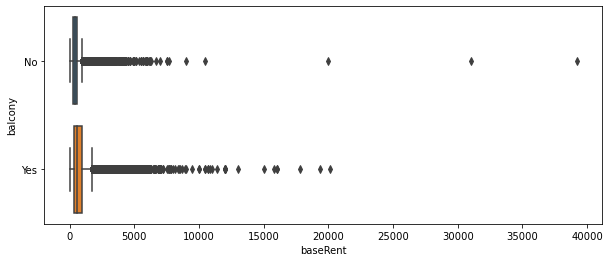

In [79]:
#Plot box plot of rentals versus balcony
plt.figure(figsize = (10, 4))
sns.boxplot(data = rentals, x = 'baseRent', y = 'balcony');

We observe slighlty higher prices for properties with balcony than those without a balcony.

## Box plot of base rents given properties's have or do not have a kitchen

In [80]:
#Replace true / false with yes / no for hasKitchen
rentals.hasKitchen = rentals.hasKitchen.replace({True: 'Yes', False: 'No'})

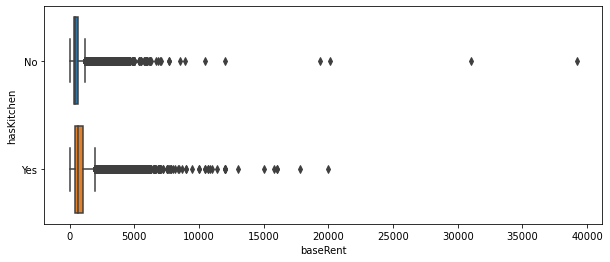

In [81]:
#Plot box plot of rentals versus hasKitchen
plt.figure(figsize = (10, 4))
sns.boxplot(data = rentals, x = 'baseRent', y = 'hasKitchen');

We observe a slight  advantage to owning a kitchen in terms of commanding higher rent.

## Box plot of base rents given properties's have or do not have a cellar

In [82]:
#Replace true / false with yes / no for cellar
rentals.cellar = rentals.cellar.replace({True: 'Yes', False: 'No'})

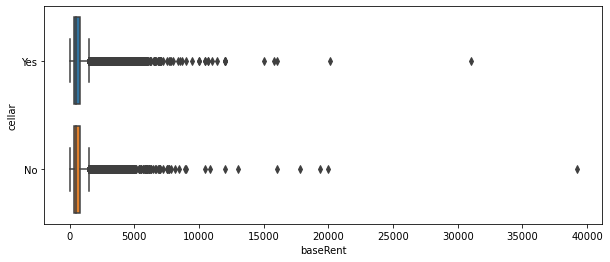

In [83]:
#Plot box plot of rentals versus cellar
plt.figure(figsize = (10, 4))
sns.boxplot(data = rentals, x = 'baseRent', y = 'cellar');

We do not observe a distinct advantage for properties with a cellar in terms of higher rent being charged.

## Box plot of base rents given properties's have or do not have a lift

In [84]:
#Replace true / false with yes / no for lift
rentals.lift = rentals.lift.replace({True: 'Yes', False: 'No'})

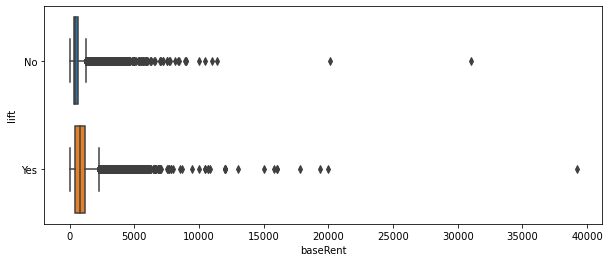

In [85]:
#Plot box plot of rentals versus lift
plt.figure(figsize = (10, 4))
sns.boxplot(data = rentals, x = 'baseRent', y = 'lift');

There seems to be a slight advantage to having a lift in terms of commanding higher rents.

## Box plot of base rents given properties's have or do not have a garden

In [86]:
#Replace true / false with yes / no for garden
rentals.garden = rentals.garden.replace({True: 'Yes', False: 'No'})

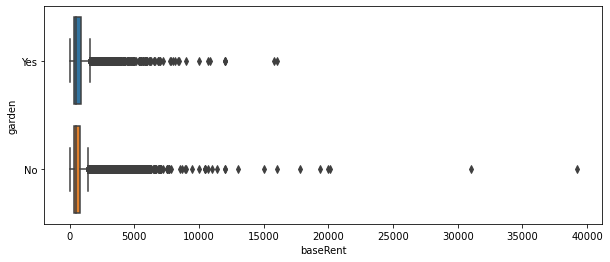

In [87]:
#Plot box plot of rentals versus garden
plt.figure(figsize = (10, 4))
sns.boxplot(data = rentals, x = 'baseRent', y = 'garden');

We do not observe a distinct advantage in having a garden with respect to charging higher rent.

# State-wide features

In [88]:
# Load and view geo-economic data
state_features = pd.read_csv('../data/processed/state_features_final.csv')

In [89]:
state_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   state                    16 non-null     object 
 1   area_km2                 16 non-null     int64  
 2   population_2019          16 non-null     int64  
 3   population_per_km2_2019  16 non-null     int64  
 4   gdp_per_capita_2018      16 non-null     int64  
 5   hdi_2018                 16 non-null     float64
dtypes: float64(1), int64(4), object(1)
memory usage: 896.0+ bytes


In [90]:
state_features.head()

,state,area_km2,population_2019,population_per_km2_2019,gdp_per_capita_2018,hdi_2018
0,Baden_Württemberg,35752,11100394,310,47290,0.953
1,Bayern,70552,13124737,185,48323,0.947
2,Berlin,892,3669491,4086,41967,0.950
3,Brandenburg,29479,2521893,85,29541,0.914
4,Bremen,419,681202,1630,49215,0.951


In [91]:
state_features.state.unique()

array(['Baden_Württemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen',
       'Hamburg', 'Hessen', 'Niedersachsen', 'Mecklenburg_Vorpommern',
       'Nordrhein_Westfalen', 'Rheinland_Pfalz', 'Saarland', 'Sachsen',
       'Sachsen_Anhalt', 'Schleswig_Holstein', 'Thüringen'], dtype=object)

## Combing state_summary information with state_features

In [92]:
state_df = state_features.join(state_summary, on= 'state', how = 'inner')
state_df.head()

,state,area_km2,population_2019,population_per_km2_2019,gdp_per_capita_2018,hdi_2018,noListings_state,noZipCodes_state,noMunicipalities_state,noCitiesTowns,...,totalLivingSpace_state,medianLivingSpace_state,medianServiceCharge_state,medianInternetUploadSpeed_state,medianBaseRent_state,medianThermalChar_state,medianFloor_state,medianNoFloors_state,medianHeatingCosts_state,medianPictureCount_state
0,Baden_Württemberg,35752,11100394,310,47290,0.953,16015,1104,1048,42,...,1347084.94,81.245,170.0,40.0,850.00,99.00,2.0,3.0,76.525,9.0
1,Bayern,70552,13124737,185,48323,0.947,21531,1535,1656,81,...,1722613.18,76.000,160.0,40.0,850.00,98.80,2.0,3.0,80.000,10.0
2,Berlin,892,3669491,4086,41967,0.950,10342,214,79,1,...,847033.36,72.060,165.0,40.0,945.00,105.00,2.0,5.0,75.280,10.0
3,Brandenburg,29479,2521893,85,29541,0.914,6914,241,334,18,...,477684.33,62.620,120.0,40.0,392.77,95.50,2.0,3.0,70.000,7.0
4,Bremen,419,681202,1630,49215,0.951,2958,45,88,2,...,215605.10,68.000,140.0,40.0,500.00,122.95,2.0,3.0,72.000,8.0


In [93]:
rentals.state.unique()

array(['Nordrhein_Westfalen', 'Rheinland_Pfalz', 'Sachsen', 'Bremen',
       'Schleswig_Holstein', 'Baden_Württemberg', 'Thüringen', 'Hessen',
       'Niedersachsen', 'Bayern', 'Hamburg', 'Sachsen_Anhalt',
       'Mecklenburg_Vorpommern', 'Berlin', 'Brandenburg', 'Saarland'],
      dtype=object)

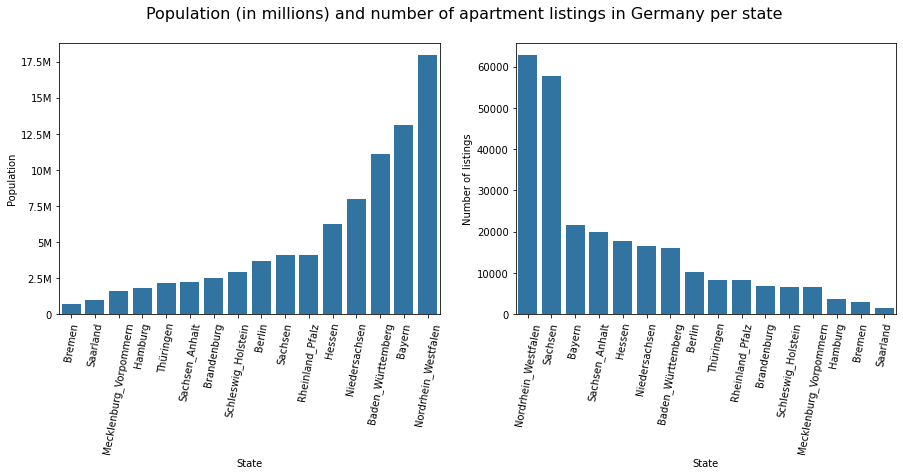

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
fig = plt.gcf()
fig.suptitle("Population (in millions) and number of apartment listings in Germany per state", fontsize = 16)
sns.barplot(data = state_df[['state', 'population_2019']].sort_values(by = 'population_2019'), x = 'state', y = 'population_2019', ax = ax1, color = 'C0')
ax1.set_xlabel('State')
ax1.set_ylabel('Population')
ax1.set_yticks([0, 0.25* 10 **7, 0.5* 10 **7, 0.75* 10 **7, 1* 10 **7, 1.25* 10 **7, 1.5* 10 **7, 1.75* 10 **7])
ax1.set_yticklabels(['0', '2.5M', '5M', '7.5M', '10M', '12.5M', '15M', '17.5M'])
ax1.tick_params(axis='x', labelrotation= 80)
sns.barplot(data = pd.DataFrame(rentals.state.value_counts()).reset_index(), y = 'state', x = 'index', color = 'C0')
ax2.set_xlabel('State')
ax2.set_ylabel('Number of listings')
ax2.tick_params(axis='x', labelrotation= 80)
plt.savefig('../reports/figures/state_listings_pop_distr.png', bbox_inches="tight");

## Calculating state area and population densities

Calculating area and population densities may give us a better sense for the variation of the base rent. It should be noted that we are making a big assumption that the 2019 population from wikipedia remains the same over time for each state.

In [95]:
#Creating state_wide area density features
state_df['no_Listings_per_km2'] = state_df.noListings_state / state_df.area_km2
state_df['noZipCodes_per_10km2'] = state_df.noZipCodes_state * 10 / state_df.area_km2
state_df['noMunicipalities_per_10km2'] = state_df.noMunicipalities_state * 10 / state_df.area_km2
state_df['nocCitiesTowns_per_1000km2'] = state_df.noCitiesTowns * 1000 / state_df.area_km2
state_df['totalLivingSpace_km2_per_10000km2'] = state_df.totalLivingSpace_state * 10000 / (1000_000 * state_df.area_km2)
state_df['totalNoRooms_per_km2'] = state_df.totalNoRooms_state / state_df.area_km2

#Creating state_wide population density features based on the 2019 population
state_df['no_Listings_per_100people'] = state_df.noListings_state * 100 / state_df.population_2019
state_df['noZipCodes_per_10kpeople'] = state_df.noZipCodes_state * 10_000 / state_df.population_2019
state_df['noMunicipalities_per_10kpeople'] = state_df.noMunicipalities_state * 10_000 / state_df.population_2019
state_df['nocCitiesTowns_per_1Mpeople'] = state_df.noCitiesTowns * 1_000_000 / state_df.population_2019
state_df['totalLivingSpace_m2_per_person'] = state_df.totalLivingSpace_state / state_df.population_2019
state_df['totalNoRooms_per_100people'] = state_df.totalNoRooms_state * 100 / state_df.population_2019

In [96]:
state_df

,state,area_km2,population_2019,population_per_km2_2019,gdp_per_capita_2018,hdi_2018,noListings_state,noZipCodes_state,noMunicipalities_state,noCitiesTowns,...,noMunicipalities_per_10km2,nocCitiesTowns_per_1000km2,totalLivingSpace_km2_per_10000km2,totalNoRooms_per_km2,no_Listings_per_100people,noZipCodes_per_10kpeople,noMunicipalities_per_10kpeople,nocCitiesTowns_per_1Mpeople,totalLivingSpace_m2_per_person,totalNoRooms_per_100people
0,Baden_Württemberg,35752,11100394,310,47290,0.953,16015,1104,1048,42,...,0.293130,1.174759,0.376786,1.283276,0.144274,0.994559,0.944111,3.783649,0.121355,0.413316
1,Bayern,70552,13124737,185,48323,0.947,21531,1535,1656,81,...,0.234720,1.148089,0.244162,0.809787,0.164049,1.169547,1.261740,6.171552,0.131249,0.435301
2,Berlin,892,3669491,4086,41967,0.950,10342,214,79,1,...,0.885650,1.121076,9.495890,29.638229,0.281837,0.583187,0.215289,0.272517,0.230831,0.720462
3,Brandenburg,29479,2521893,85,29541,0.914,6914,241,334,18,...,0.113301,0.610604,0.162042,0.601920,0.274159,0.955631,1.324402,7.137496,0.189415,0.703598
4,Bremen,419,681202,1630,49215,0.951,2958,45,88,2,...,2.100239,4.773270,5.145706,18.439141,0.434232,0.660597,1.291834,2.935987,0.316507,1.134172
5,Hamburg,755,1847253,2439,66879,0.975,3740,109,94,1,...,1.245033,1.324503,4.144909,13.432318,0.202463,0.590065,0.508864,0.541344,0.169409,0.548999
6,Hessen,21115,6288080,297,46923,0.949,17729,556,485,25,...,0.229695,1.183992,0.696449,2.302226,0.281946,0.884213,0.771301,3.975776,0.233863,0.773074
7,Niedersachsen,47609,7993448,168,38423,0.922,16536,709,818,46,...,0.171816,0.966204,0.267317,0.954882,0.206869,0.886976,1.023338,5.754713,0.159214,0.568728
8,Mecklenburg_Vorpommern,23180,1609675,69,28940,0.910,6621,197,462,18,...,0.199310,0.776531,0.180796,0.727623,0.411325,1.223850,2.870145,11.182382,0.260354,1.047808
9,Nordrhein_Westfalen,34085,17932651,526,39678,0.936,62696,1070,1031,53,...,0.302479,1.554936,1.367257,4.917261,0.349619,0.596677,0.574929,2.955503,0.259878,0.934635


## Relationship between base rent and the total area and population of the state

In [97]:
#Create function to annotate plots with state names
def annotate(df, feature, target, ax):    
    x = df[feature]
    y = df[target]
    state = df['state']
    for s, x, y in zip(state, x, y):
        ax.annotate(s, (x, y))

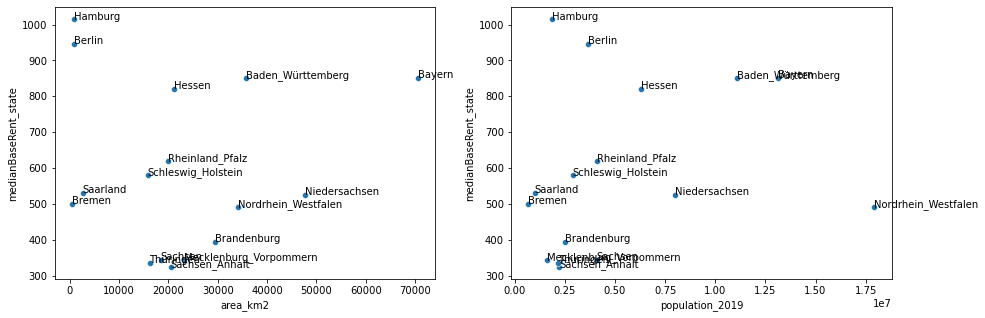

In [98]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
sns.scatterplot(data = state_df, x = 'area_km2' , y = 'medianBaseRent_state', ax = ax1)
annotate(state_df, 'area_km2', 'medianBaseRent_state', ax1)
sns.scatterplot(data = state_df, x = 'population_2019' , y = 'medianBaseRent_state')
annotate(state_df, 'population_2019', 'medianBaseRent_state', ax2);

We do not observe a pattern between the medium base rent of a state and either its population or its area.

## Relationship between base rent and population per state area

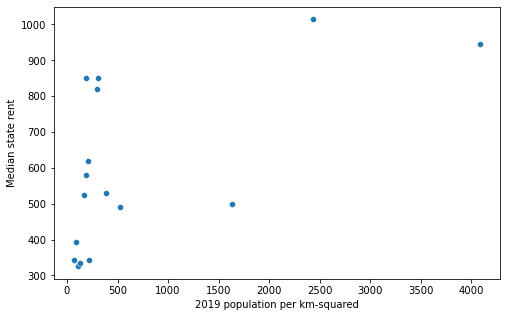

In [99]:
fig, ax = plt.subplots(figsize = (8,5))
sns.scatterplot(data = state_df, x = 'population_per_km2_2019' , y = 'medianBaseRent_state')
#annotate(state_df, 'population_per_km2_2019', 'medianBaseRent_state', ax)
plt.xlabel('2019 population per km-squared')
plt.ylabel('Median state rent')
plt.savefig('../reports/figures/pop_per_area.png', bbox_inches="tight");

We observe a power pattern between the median base rent of a state and the population per area.

## Relationship between base rent and the gdp per capita and human development index of the state

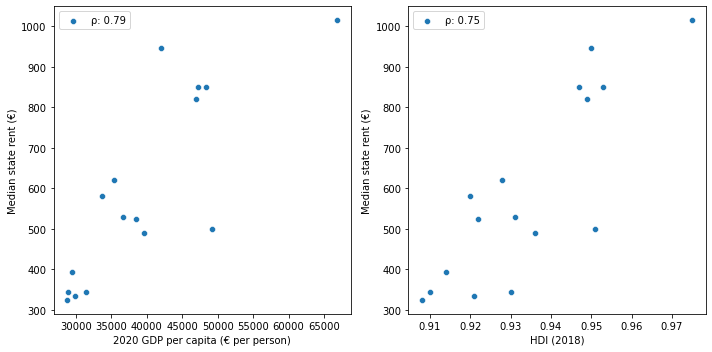

In [100]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
gdp_corr = stats.spearmanr(state_df.gdp_per_capita_2018, state_df.medianBaseRent_state)[0]
sns.scatterplot(data = state_df, x = 'gdp_per_capita_2018' , y = 'medianBaseRent_state', ax = ax1, label = f'ρ: {gdp_corr:.2f}')
#annotate(state_df, 'gdp_per_capita_2018', 'medianBaseRent_state', ax1)
ax1.set_xlabel('2020 GDP per capita (€ per person)')
ax1.set_ylabel('Median state rent (€)')
#ax1.legend()
hmi_corr = stats.spearmanr(state_df.hdi_2018, state_df.medianBaseRent_state)[0]
sns.scatterplot(data = state_df, x = 'hdi_2018' , y = 'medianBaseRent_state', ax = ax2, label = f'ρ: {hmi_corr:.2f}')
#annotate(state_df, 'hdi_2018', 'medianBaseRent_state', ax2)
ax2.set_xlabel('HDI (2018)')
ax2.set_ylabel('Median state rent (€)')
plt.tight_layout()
plt.savefig('../reports/figures/gdp_hmi.png', bbox_inches="tight");

We observe a positive relationship between a state's median base rent and the gdp per capita of the state, as well as the human development index of the state.

## Relationship between base rent  and the number of zip codes, municipalities and cities / towns per area of state

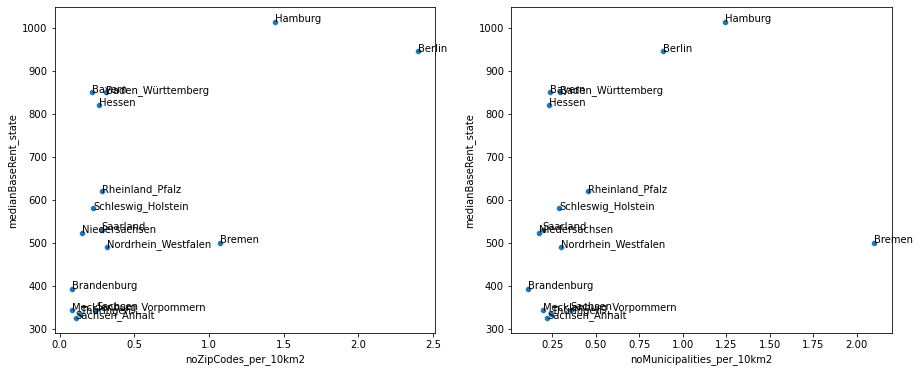

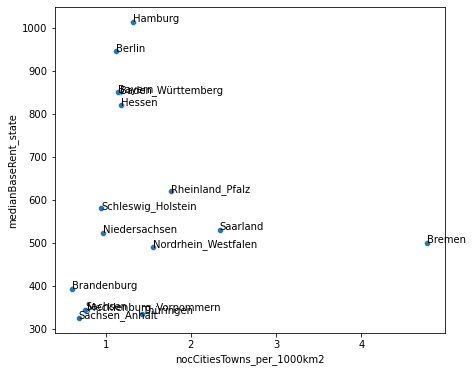

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))
sns.scatterplot(data = state_df, x = 'noZipCodes_per_10km2' , y = 'medianBaseRent_state', ax = ax1)
annotate(state_df, 'noZipCodes_per_10km2', 'medianBaseRent_state', ax1)
sns.scatterplot(data = state_df, x = 'noMunicipalities_per_10km2' , y = 'medianBaseRent_state', ax = ax2)
annotate(state_df, 'noMunicipalities_per_10km2', 'medianBaseRent_state', ax2)
plt.show()
fig, ax = plt.subplots(figsize = (7, 6))
sns.scatterplot(data = state_df, x = 'nocCitiesTowns_per_1000km2' , y = 'medianBaseRent_state', ax = ax)
annotate(state_df, 'nocCitiesTowns_per_1000km2', 'medianBaseRent_state', ax)
plt.show()

There is no clear pattern between the median base rent and the total number of zip codes, municipalities and cities/towns per area of the state.

## Relationship between base rent and the total number of listing, total living area, and total number of rooms per area of state

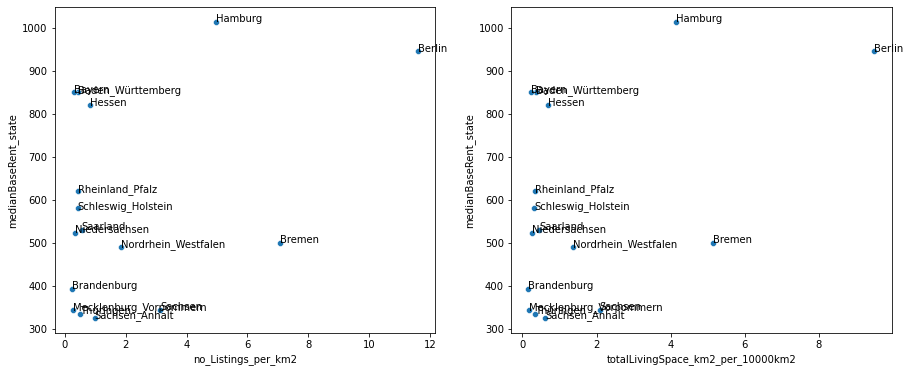

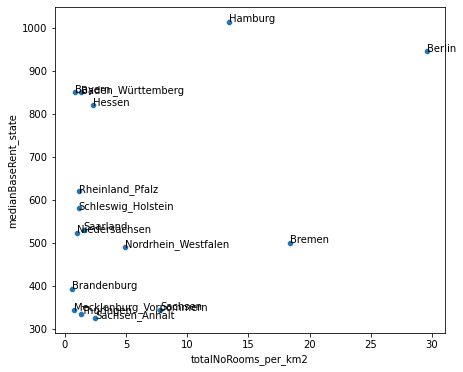

In [102]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))
sns.scatterplot(data = state_df, x = 'no_Listings_per_km2' , y = 'medianBaseRent_state', ax = ax1)
annotate(state_df, 'no_Listings_per_km2', 'medianBaseRent_state', ax1)
sns.scatterplot(data = state_df, x = 'totalLivingSpace_km2_per_10000km2' , y = 'medianBaseRent_state', ax = ax2)
annotate(state_df, 'totalLivingSpace_km2_per_10000km2', 'medianBaseRent_state', ax2)
plt.show()
fig, ax = plt.subplots(figsize = (7, 6))
sns.scatterplot(data = state_df, x = 'totalNoRooms_per_km2' , y = 'medianBaseRent_state', ax = ax)
annotate(state_df, 'totalNoRooms_per_km2', 'medianBaseRent_state', ax)
plt.show()

We do not see a clear pattern between the base rent and the total number of listings per km2 of state, total living area per 10000km2 of state area, and the total number of rooms per state km2. 

## Relationship between base rent and the total number of zip codes, municipalities and cities per population of the state

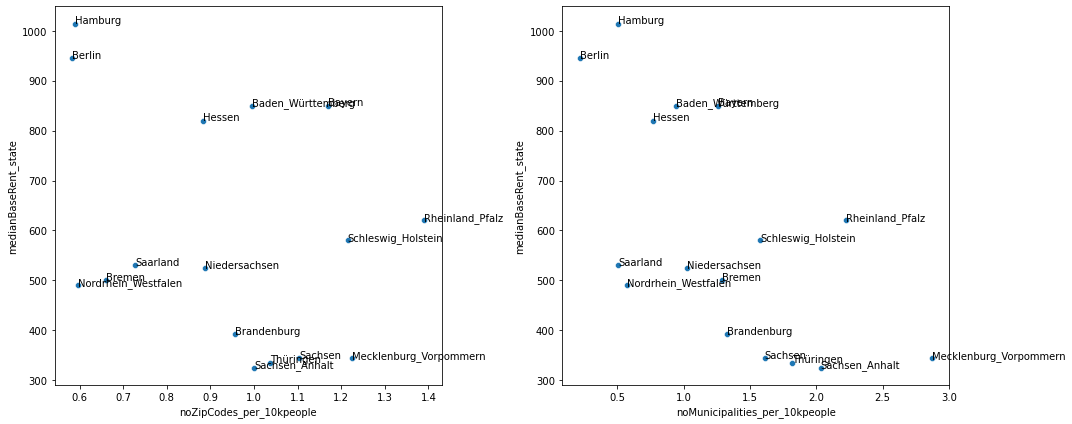

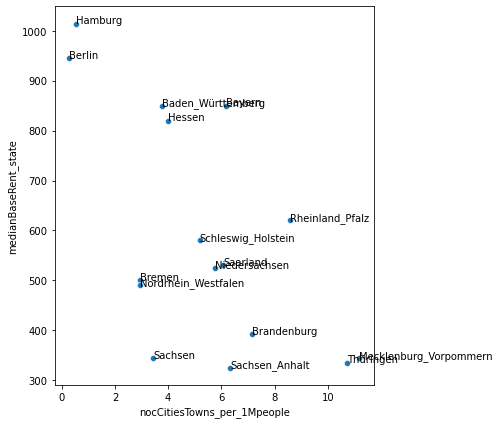

In [103]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))
sns.scatterplot(data = state_df, x = 'noZipCodes_per_10kpeople' , y = 'medianBaseRent_state', ax = ax1)
annotate(state_df, 'noZipCodes_per_10kpeople', 'medianBaseRent_state', ax1)
sns.scatterplot(data = state_df, x = 'noMunicipalities_per_10kpeople' , y = 'medianBaseRent_state', ax = ax2)
annotate(state_df, 'noMunicipalities_per_10kpeople', 'medianBaseRent_state', ax2)
plt.tight_layout()
plt.show()
fig, ax = plt.subplots(figsize = (7, 6))
sns.scatterplot(data = state_df, x = 'nocCitiesTowns_per_1Mpeople' , y = 'medianBaseRent_state', ax = ax)
annotate(state_df, 'nocCitiesTowns_per_1Mpeople', 'medianBaseRent_state', ax)
plt.tight_layout()
plt.show()


We do not observe a relationship with the number of zip codes per 10k people, number of municipalities per 10k people, or the number of cities / towns per 1M people.

## Relationship between base rent and the total number of listings, total living area and total number of rooms available per the population of the state

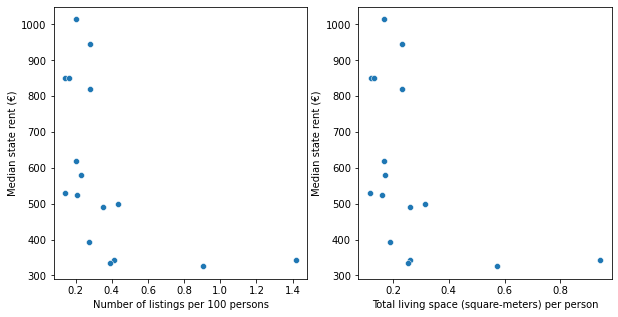

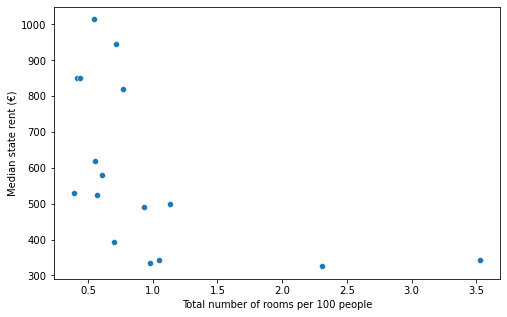

In [104]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
sns.scatterplot(data = state_df, x = 'no_Listings_per_100people' , y = 'medianBaseRent_state', ax = ax1)
ax1.set_ylabel('Median state rent (€)')
ax1.set_xlabel('Number of listings per 100 persons')
#annotate(state_df, 'no_Listings_per_100people', 'medianBaseRent_state', ax1)
sns.scatterplot(data = state_df, x = 'totalLivingSpace_m2_per_person' , y = 'medianBaseRent_state', ax = ax2)
#annotate(state_df, 'totalLivingSpace_m2_per_person', 'medianBaseRent_state', ax2)
ax2.set_ylabel('Median state rent (€)')
ax2.set_xlabel('Total living space (square-meters) per person')
#plt.savefig('..\\reports\\figures\\listings_space.png', bbox_inches="tight")
#plt.show()
fig, ax = plt.subplots(figsize = (8, 5))
sns.scatterplot(data = state_df, x = 'totalNoRooms_per_100people' , y = 'medianBaseRent_state', ax = ax)
#annotate(state_df, 'totalNoRooms_per_100people', 'medianBaseRent_state', ax)
ax.set_ylabel('Median state rent (€)')
ax.set_xlabel('Total number of rooms per 100 people')
plt.savefig('../reports/figures/totals_per_pop.png', bbox_inches="tight")
#plt.show();

We observe a decay relationship between the median base rent and the total number of listings per 100 people, the total living space per person and the total number of rooms per person in the state. 

# Summary 

- The time does not seem to be a factor in influencing base rent. Whether it is the day the property was constructed, refurbished, or posted for rent, we do not observe a clear time-dependent relationship. 
- We investigated weather there was a relationship between the median base rent and how many cities / towns were in a state; how many muncipalities were in a state or city / town; and how many zip codes were in a state, city / town, or municipality. None of these aggregate values seemed to offer a pattern for base rent.
- We also examined how total demand quantities, such as the total number of listings, rooms, and living areas, at a state, city / town, municipality, and zip code level affected base rent. We observed no significant patterns in these relationships.
- Our first patterns appeared when we examined the relationship between the base rent and the number of rooms. There appeared to be a slight positive relationship between these two variables when we examined their relationship at the listings, municipality and zip code level. However, no such trends were observed at the state or city / town levels. 
- The positive relationship between base rent and living area was pronounced at all levels - considering all listings; and median base rents at the city / town, municipality, and zip code level.
- The same positive trend as for living area was observed for service charge, althought the relationship between base rent and this feature was more muted at the total listings level.
- Therma char seem to offer a negative relationship with median base rent at the state and city / town level, which was not obvious at the total lsitings, municipality or zip code level.
- The internet upload speed, number of floors, floor number did not seem to present a pattern of relationship with base rent; although, we observed a peculiar trend with the picture count where there was a slight positive relationship with base rent at the state, city and zip code levels, but not at the municipality or total number of listings level. 
- Some categorical features seem to offer variation in terms of the rent commanded:
- We observed higher rents for properties with interior quality labelled as luxury and sophisticated; with condition labelled as first-time-use, mint-condition, and first-time-use-after-refurbishment; and with type of flat labelled as a pent house, loft, maisonette, or terraced-flat.
- We did not observe a significant relationship with base rent for such features as the availability of a tv offer or the allowance of a pet. 
- We noticed slightly higher base rents for properties that were new, that had a kitchen, that had a balcony, and that had a lift. - It did not seem like the availability of a garden or a cellar affected base rent.
- We finally, examined state-wide information we obtained from wikipedia to understand their impact on base rent. 
- We observed that median base rent of the state positively correlated with the gdp_per_capita and the human development index of the state.
- After calculating area and population densities for each state, the most importance relationships were observed between the median base rent of the state and the population densities when we considered the total number of listings, the total living area and the total number of rooms available in the state. The area densities did not seem to affect base rent. 

From our review, we will be dropping the following features, as they did not present any patterns with base rent. They include:
- All the time features
- Aggregate figures such as the total number of cities / towns, municipalities, and zip codes at a state-wide, city / town, and municipality basis, where computed.
- Total demand quantities for listings, rooms and living area at all geographical levels.
- Internet upload speed, number of floors, floor number.
- tvOffer, petAllowed


In [105]:
#Drop features from rentals data frame
drop_features_rentals = ['internetUploadSpeed', 'cellar', 'petsAllowed', 'garden', 'lastRefurbish', 'yearConstructed', \
                         'date', 'floor', 'numberOfFloors', 'tvOffer', 'picturecount', 'thermalChar', 'heatingCosts']
rentals_final = rentals.drop(columns = drop_features_rentals)

In [106]:
#Drop features from state_df data frame
drop_features_state = ['noCitiesTowns', 'population_per_km2_2019','noMunicipalities_state', 'area_km2', 
                       'population_2019', 'noListings_state', 'totalLivingSpace_state', 
        'noZipCodes_state', 'noMunicipalities_state', 'noCitiesTowns', 'totalNoRooms_state',
        'medianInternetUploadSpeed_state', 'medianFloor_state', 'medianNoFloors_state', 
        'no_Listings_per_km2', 'noZipCodes_per_10km2', 'noMunicipalities_per_10km2', 'nocCitiesTowns_per_1000km2',
       'totalLivingSpace_km2_per_10000km2', 'totalNoRooms_per_km2', 'noZipCodes_per_10kpeople',
       'noMunicipalities_per_10kpeople', 'nocCitiesTowns_per_1Mpeople', 'medianNoRooms_state']

In [107]:
state_final = state_df.drop(columns = drop_features_state)

In [108]:
#Drop features from city_town_summary dataframe
drop_features_ct = ['noListings_ct', 'noZipCodes_ct', 'noMunicipalities_ct',
       'totalNoRooms_ct', 'totalLivingSpace_ct', 'medianFloor_ct', 'medianNoFloors_ct', 'medianInternetUploadSpeed_ct',
                   'medianNoRooms_ct', 'medianHeatingCosts_ct']

In [109]:
city_town_final = city_town_summary.drop(columns = drop_features_ct)

In [110]:
#Drop features from municipality_summary dataframe
drop_features_muni = ['noListings_muni', 'noZipCodes_muni', 'totalNoRooms_muni', 'totalLivingSpace_muni',
                     'medianInternetUploadSpeed_muni', 'medianFloor_muni',
       'medianNoFloors_muni', 'medianThermalChar_muni', 'medianHeatingCosts_muni']

In [111]:
municipality_final = municipality_summary.drop(columns = drop_features_muni)

In [112]:
#Drop features from zip_code_summary dataframe
drop_features_zip = ['noListings_zip', 'totalNoRooms_zip', 'totalLivingSpace_zip', 'medianInternetUploadSpeed_zip', 
                     'medianFloor_zip', 'medianNoFloors_zip', 'medianHeatingCosts_zip', 'medianThermalChar_zip',
                   'medianPictureCount_zip']

In [113]:
zip_code_final = zip_code_summary.drop(columns = drop_features_zip)

In [114]:
#Merge all data frames
rentals_complete = pd.merge(pd.merge(pd.merge(pd.merge(rentals_final, state_final, on= 'state', how = 'inner'), 
         city_town_final, on = 'city_town', how = 'inner'), 
         municipality_final, on = 'municipality', how = 'inner'), zip_code_final, on = 'zip_code', how = 'inner')

In [115]:
rentals_complete.head()

,state,serviceCharge,newlyConst,balcony,hasKitchen,baseRent,livingSpace,condition,interiorQual,lift,...,medianPictureCount_ct,medianNoRooms_muni,medianLivingSpace_muni,medianServiceCharge_muni,medianBaseRent_muni,medianPictureCount_muni,medianNoRooms_zip,medianLivingSpace_zip,medianServiceCharge_zip,medianBaseRent_zip
0,Nordrhein_Westfalen,245.00,No,No,No,595.00,86.00,well_kept,normal,No,...,8.0,3.0,78.0,161.62,774.0,9.0,3.0,78.0,150.0,670.0
1,Nordrhein_Westfalen,141.00,No,Yes,No,579.00,70.95,unknown,unknown,No,...,8.0,3.0,78.0,161.62,774.0,9.0,3.0,78.0,150.0,670.0
2,Nordrhein_Westfalen,141.00,No,Yes,No,569.00,70.95,unknown,unknown,No,...,8.0,3.0,78.0,161.62,774.0,9.0,3.0,78.0,150.0,670.0
3,Nordrhein_Westfalen,322.16,Yes,Yes,Yes,1398.60,115.58,first_time_use,sophisticated,Yes,...,8.0,3.0,78.0,161.62,774.0,9.0,3.0,78.0,150.0,670.0
4,Nordrhein_Westfalen,112.92,No,No,Yes,725.62,51.10,mint_condition,sophisticated,Yes,...,8.0,3.0,78.0,161.62,774.0,9.0,3.0,78.0,150.0,670.0


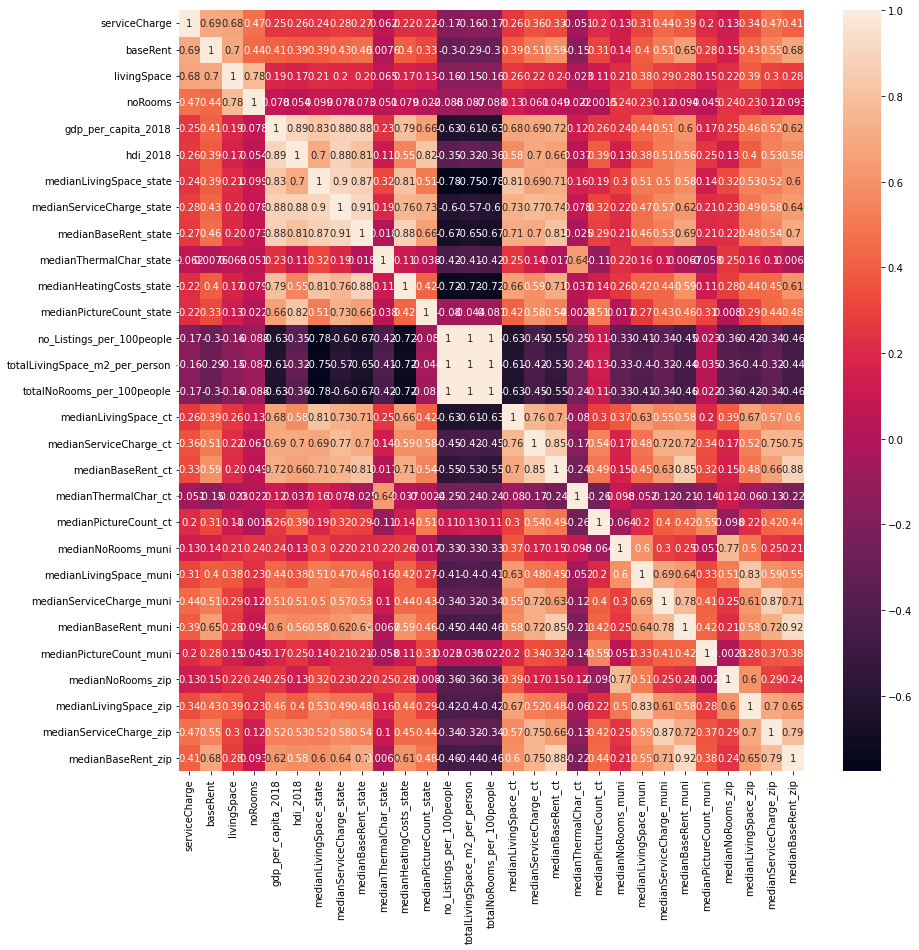

In [116]:
#View heatmap of final dataframe
plt.subplots(figsize=(14,14))
sns.heatmap(rentals_complete.corr(), annot = True);

We observe that totalLivingSpace_m2_per_person, totalNoRooms_per_100people and no_Listings_per_100people are perfectly correlated with each other. This suggests the presence of a confounding, which is the population in our case. Since base rent correlates to these factors in a similar way, we will drop two of these variables. 

We also note that the service charge and living space correlate the most with base rent. We also note that some aggregate medians correlate better with base rent than the original features.

In [117]:
#rentals_complete.drop(columns = ['totalLivingSpace_m2_per_person', 'totalNoRooms_per_100people'], inplace = True)

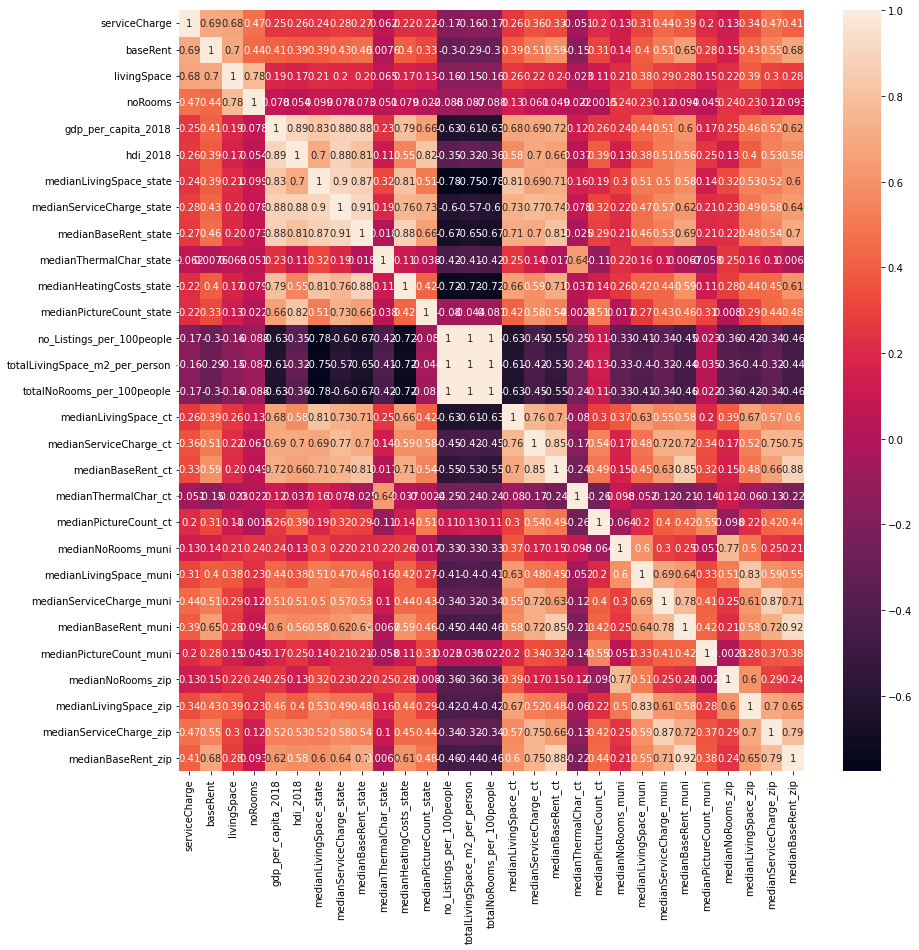

In [118]:
#View heatmap of final dataframe
plt.subplots(figsize=(14,14))
sns.heatmap(rentals_complete.corr(), annot = True);

# 7. Saving Data

In [119]:
datapath = '../data/interim'
if not os.path.exists(datapath):
    os.mkdir(datapath)

In [120]:
datapath_rentals = os.path.join(datapath, 'rentals_complete.csv')
if not os.path.exists(datapath_rentals):
    rentals_complete.to_csv(datapath_rentals, index=False)